In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from functools import reduce

orders_df = pd.read_csv(r"C:\Users\naufa\Documents\Purwadhika\Capstone Projects\04_Final Project\DataSet\olist_orders_dataset_OrdersID_CustomersID.csv")
order_items_df = pd.read_csv(r"C:\Users\naufa\Documents\Purwadhika\Capstone Projects\04_Final Project\DataSet\olist_order_items_dataset_OrderID.csv")
sellers_df = pd.read_csv(r"C:\Users\naufa\Documents\Purwadhika\Capstone Projects\04_Final Project\DataSet\olist_sellers_dataset_SellerID.csv")
customers_df = pd.read_csv(r"C:\Users\naufa\Documents\Purwadhika\Capstone Projects\04_Final Project\DataSet\olist_customers_dataset_CustomersID.csv")
geolocation_df = pd.read_csv(r"C:\Users\naufa\Documents\Purwadhika\Capstone Projects\04_Final Project\DataSet\olist_geolocation_dataset.csv")
payments_df = pd.read_csv(r"C:\Users\naufa\Documents\Purwadhika\Capstone Projects\04_Final Project\DataSet\olist_order_payments_dataset_OrderID.csv")
products_df = pd.read_csv(r"C:\Users\naufa\Documents\Purwadhika\Capstone Projects\04_Final Project\DataSet\olist_products_dataset_ProductID.csv")
product_cat_df = pd.read_csv(r"C:\Users\naufa\Documents\Purwadhika\Capstone Projects\04_Final Project\DataSet\product_category_name_translation.csv")
review_df = pd.read_csv(r"C:\Users\naufa\Documents\Purwadhika\Capstone Projects\04_Final Project\DataSet_Backup\olist_order_reviews_dataset.csv")

print("Datasets loaded successfully.")

Datasets loaded successfully.


In [2]:
print("Orders Data: ",orders_df.shape)
print("Orders Items: ", order_items_df.shape)
print("Sellers Data: ", sellers_df.shape)
print("Customers Data: ", customers_df.shape)
print("Geolocation Data: ",geolocation_df.shape)
print("Payments Data: ",payments_df.shape)
print("Products Data: ",products_df.shape)
print("Products Category: ",product_cat_df.shape)
print("Products Review: ",review_df.shape)

Orders Data:  (99441, 8)
Orders Items:  (112650, 7)
Sellers Data:  (3095, 4)
Customers Data:  (99441, 5)
Geolocation Data:  (1000163, 5)
Payments Data:  (103886, 5)
Products Data:  (32951, 9)
Products Category:  (71, 2)
Products Review:  (99224, 7)


# Exploratory Data Analysis

## Orders Dataset

In [5]:
orders = orders_df.copy()

In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [7]:
orders[["order_purchase_timestamp",
           "order_approved_at",
           'order_delivered_carrier_date',
           'order_delivered_customer_date',
           'order_estimated_delivery_date']] = (
    orders[["order_purchase_timestamp",
               "order_approved_at",
               'order_delivered_carrier_date',
               'order_delivered_customer_date',
               'order_estimated_delivery_date']]
    .apply(pd.to_datetime, format="%Y-%m-%d %H:%M:%S", errors='coerce')
)

In [8]:
orders.isnull().mean()*100

order_id                         0.000000
customer_id                      0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_approved_at                0.160899
order_delivered_carrier_date     1.793023
order_delivered_customer_date    2.981668
order_estimated_delivery_date    0.000000
dtype: float64

In [9]:
orders['order_status'].value_counts()

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

In [10]:
orders[orders['order_status']=="delivered"]['order_delivered_customer_date'].isnull().sum()

8

There are 8 delivery which has been delivered but missing a timestamp. This is quite odd and therefore will be **dropped**.

In [12]:
print(f"Orders being shipped but hasn't reached the carrier: {orders[orders['order_status']=='shipped']['order_delivered_carrier_date'].isnull().sum()}")
print(f"Orders being shipped but hasn't reached the customers: {orders[orders['order_status']=='shipped']['order_delivered_customer_date'].isnull().sum()}")

Orders being shipped but hasn't reached the carrier: 0
Orders being shipped but hasn't reached the customers: 1107


There are 1000 items that are being shipped but did not reach the customers or not tracked properly. This is quite odd and therefore will be **dropped**.

In [14]:
orders[orders['order_status']=="canceled"]['order_delivered_customer_date'].count()

6

There are 6 canceled transaction but is given a delivered timestamp. This will also be dropped as it does not make sense.

In [16]:
# Dropping them:
# Drop 'delivered' orders with missing delivered timestamp
mask_delivered_missing = (orders['order_status'] == "delivered") & (orders['order_delivered_customer_date'].isnull())

# Drop 'canceled' orders that *do* have a delivered timestamp
mask_canceled_with_timestamp = (orders['order_status'] == "canceled") & (orders['order_delivered_customer_date'].notnull())

# Combine both masks
invalid_orders_mask = mask_delivered_missing | mask_canceled_with_timestamp

# Count how many will be removed
print(f"Total invalid orders to drop: {invalid_orders_mask.sum()}")

# Drop them
orders = orders[~invalid_orders_mask].copy()

# Sanity check
print(f"Cleaned dataset shape: {orders.shape}")
print(f"'delivered' orders missing timestamp: {orders[(orders['order_status']=='delivered') & (orders['order_delivered_customer_date'].isnull())].shape[0]}")
print(f"'canceled' orders with timestamp: {orders[(orders['order_status']=='canceled') & (orders['order_delivered_customer_date'].notnull())].shape[0]}")

Total invalid orders to drop: 14
Cleaned dataset shape: (99427, 8)
'delivered' orders missing timestamp: 0
'canceled' orders with timestamp: 0


In [17]:
orders[orders['order_delivered_carrier_date'].isnull()]['order_status'].value_counts(normalize=True)*100

order_status
unavailable    34.175084
canceled       30.864198
invoiced       17.620651
processing     16.891134
created         0.280584
approved        0.112233
delivered       0.056117
Name: proportion, dtype: float64

In [18]:
#The estimated delivery time
orders['order_estimated_duration'] = (
    orders['order_estimated_delivery_date'] - orders['order_purchase_timestamp']
)

#Actual Delivery Time
orders['order_delivery_time'] = (
    orders['order_delivered_customer_date'] - orders['order_delivered_carrier_date']
)

#On Time or Delayed Delivery Status
orders['order_delivery_delay'] = (
    orders['order_delivered_customer_date'] - orders['order_estimated_delivery_date']
)

# Converting Them Into Hours
orders['order_estimated_duration_hours'] = orders['order_estimated_duration'].dt.total_seconds() / 3600
orders['order_delivery_time_hours'] = orders['order_delivery_time'].dt.total_seconds() / 3600
orders['order_delivery_delay_hours'] = orders['order_delivery_delay'].dt.total_seconds() / 3600

In [19]:
orders.describe()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_estimated_duration,order_delivery_time,order_delivery_delay,order_estimated_duration_hours,order_delivery_time_hours,order_delivery_delay_hours
count,99427,99267,97645,96470,99427,99427,96469,96470,99427.000000,96469.000000,96470.000000
mean,2017-12-31 09:03:23.721957120,2017-12-31 18:55:39.589531648,2018-01-04 22:07:02.372451072,2018-01-14 12:41:33.581683456,2018-01-24 03:26:44.678809600,23 days 18:23:20.956852766,9 days 07:55:37.665809742,-12 days +19:43:29.937027056,570.389155,223.927129,-268.275017
min,2016-09-04 21:15:19,2016-09-15 12:16:38,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-09-30 00:00:00,1 days 15:34:33,-17 days +21:41:31,-147 days +23:36:47,39.575833,-386.308056,-3504.386944
25%,2017-09-12 15:11:19.500000,2017-09-12 23:52:50.500000,2017-09-15 22:31:52,2017-09-25 22:15:09.500000,2017-10-03 00:00:00,18 days 07:56:43,4 days 02:24:04,-17 days +18:08:32.750000,439.945278,98.401111,-389.857569
50%,2018-01-18 23:04:36,2018-01-19 11:36:13,2018-01-24 16:09:18,2018-02-02 19:32:21,2018-02-15 00:00:00,23 days 05:45:53,7 days 02:23:40,-12 days +01:14:44,557.764722,170.394444,-286.754444
75%,2018-05-04 15:29:15.500000,2018-05-04 20:15:20.500000,2018-05-08 13:36:00,2018-05-15 22:54:48.500000,2018-05-25 00:00:00,28 days 10:11:37.500000,12 days 00:41:15,-7 days +14:38:40,682.193750,288.687500,-153.355556
max,2018-10-17 17:30:18,2018-09-03 17:40:06,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-11-12 00:00:00,155 days 03:15:04,205 days 04:35:00,188 days 23:24:07,3723.251111,4924.583333,4535.401944
std,NaN,NaN,NaN,NaN,NaN,8 days 19:55:41.237913044,8 days 18:14:17.405281128,10 days 04:25:28.179310468,211.928122,210.238168,244.424494


In [20]:
#Average estimated package arrival
print(f"The average estimated delivery time: {orders['order_estimated_duration_hours'].mean()/24}, and the maximum is {orders['order_estimated_duration_hours'].max()/24}")

#Average time the package is delivered to the customers
print(f"The average actual package arrival time: {orders['order_delivery_time_hours'].mean()/24}, while the maximum is {orders['order_delivery_time_hours'].max()/24}")

#Arrival status, late or on-time
print(f"The average time the package arrived from the estimated arrival date: {orders['order_delivery_delay_hours'].mean()/24}")

#Comparison between those who is late, and those who are not:
orders['order_arrival_status'] = np.where(
    orders['order_delivery_delay_hours'] > 0, 1, 0
)

The average estimated delivery time: 23.766214778388502, and the maximum is 155.13546296296298
The average actual package arrival time: 9.330297057983126, while the maximum is 205.1909722222222
The average time the package arrived from the estimated arrival date: -11.17812572885353


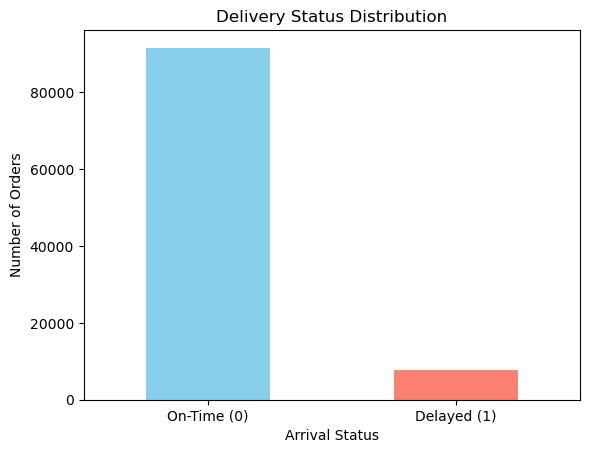

order_arrival_status
0    0.921289
1    0.078711
Name: proportion, dtype: float64


In [21]:
orders['order_arrival_status'].value_counts().plot(
    kind='bar',
    color=['skyblue', 'salmon'],
    rot=0
)
plt.xticks([0,1], ['On-Time (0)', 'Delayed (1)'])
plt.title('Delivery Status Distribution')
plt.xlabel('Arrival Status')
plt.ylabel('Number of Orders')
plt.show()

print(orders['order_arrival_status'].value_counts(normalize=True))

Observation:
- Our e-Commerce delivery prediction is not as accurate, making it easier to reach. Seems like a business decision to avoid risks instead of aiming for accuracies. The difference in the average delivery time and the estimated arrival time is 14 days, which is very big.
- Thus can be seen here in the charts, where it recognizes only 7% of delayed order, which is low and good on papers, but might not be as accurate. We might need to consider to make it closer to actual market condition.
- Data or entries with missing delivered date can be assumed is currently still in other steps of the purchasing process or simply have not arrived yet.

In [23]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99427 entries, 0 to 99440
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype          
---  ------                          --------------  -----          
 0   order_id                        99427 non-null  object         
 1   customer_id                     99427 non-null  object         
 2   order_status                    99427 non-null  object         
 3   order_purchase_timestamp        99427 non-null  datetime64[ns] 
 4   order_approved_at               99267 non-null  datetime64[ns] 
 5   order_delivered_carrier_date    97645 non-null  datetime64[ns] 
 6   order_delivered_customer_date   96470 non-null  datetime64[ns] 
 7   order_estimated_delivery_date   99427 non-null  datetime64[ns] 
 8   order_estimated_duration        99427 non-null  timedelta64[ns]
 9   order_delivery_time             96469 non-null  timedelta64[ns]
 10  order_delivery_delay            96470 non-null  timedelta64[ns]

In [24]:
orders['order_date'] = orders['order_purchase_timestamp'].dt.date
top_order_days = orders['order_date'].value_counts().head(10)
print(top_order_days)

order_date
2017-11-24    1176
2017-11-25     499
2017-11-27     403
2017-11-26     391
2017-11-28     379
2018-05-07     372
2018-08-06     372
2018-08-07     370
2018-05-14     364
2018-05-16     357
Name: count, dtype: int64


## Customers Dataset

In [26]:
customers = customers_df.copy()

In [27]:
main = orders.merge(customers,on='customer_id',how='left')

In [28]:
customers['customer_id'].nunique()

99441

In [29]:
customers['customer_unique_id'].nunique()

96096

In [30]:
main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99427 entries, 0 to 99426
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype          
---  ------                          --------------  -----          
 0   order_id                        99427 non-null  object         
 1   customer_id                     99427 non-null  object         
 2   order_status                    99427 non-null  object         
 3   order_purchase_timestamp        99427 non-null  datetime64[ns] 
 4   order_approved_at               99267 non-null  datetime64[ns] 
 5   order_delivered_carrier_date    97645 non-null  datetime64[ns] 
 6   order_delivered_customer_date   96470 non-null  datetime64[ns] 
 7   order_estimated_delivery_date   99427 non-null  datetime64[ns] 
 8   order_estimated_duration        99427 non-null  timedelta64[ns]
 9   order_delivery_time             96469 non-null  timedelta64[ns]
 10  order_delivery_delay            96470 non-null  timedelta6

Total unique customers: 96,082
One-time buyers: 93,085 (96.88%)
Repeat buyers: 2,997 (3.12%)


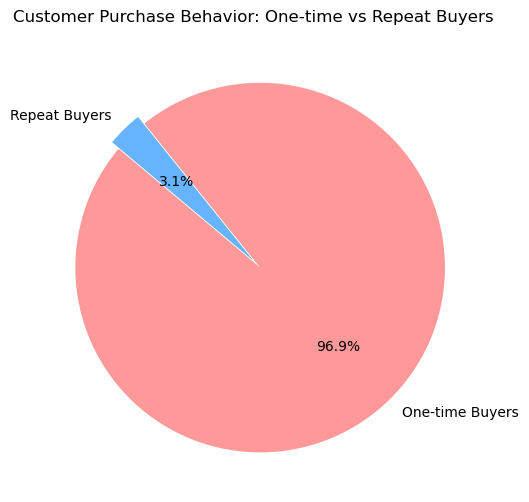

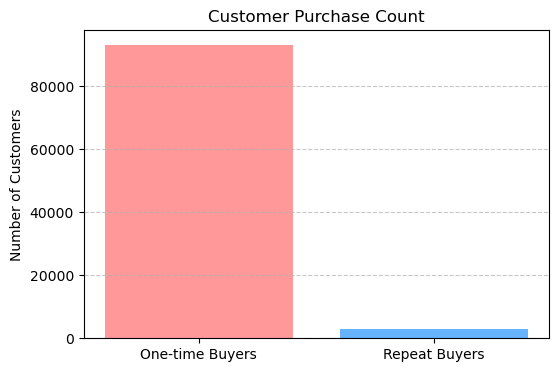

In [31]:
# Calculate counts
repeat_counts = main['customer_unique_id'].value_counts()
one_time_buyers = (repeat_counts == 1).sum()
repeat_buyers = (repeat_counts > 1).sum()

# Summary printout
total_customers = main['customer_unique_id'].nunique()
print(f"Total unique customers: {total_customers:,}")
print(f"One-time buyers: {one_time_buyers:,} ({one_time_buyers / total_customers:.2%})")
print(f"Repeat buyers: {repeat_buyers:,} ({repeat_buyers / total_customers:.2%})")

#Visualization
# Pie Chart
labels = ['One-time Buyers', 'Repeat Buyers']
sizes = [one_time_buyers, repeat_buyers]
colors = ['#ff9999','#66b3ff']

plt.figure(figsize=(6,6))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    explode=(0.05, 0)  # slightly pop out the first slice
)
plt.title('Customer Purchase Behavior: One-time vs Repeat Buyers')
plt.show()

# Bar Chart
plt.figure(figsize=(6,4))
plt.bar(labels, sizes, color=colors)
plt.title('Customer Purchase Count')
plt.ylabel('Number of Customers')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

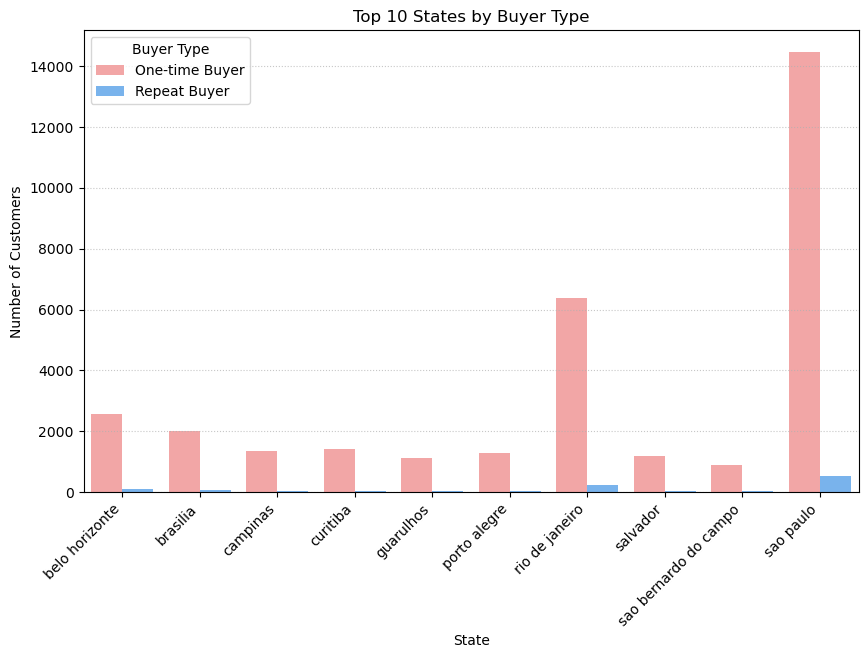

In [32]:
# Count purchase frequency per unique customer
customer_order_counts = main['customer_unique_id'].value_counts().reset_index()
customer_order_counts.columns = ['customer_unique_id', 'order_count']

# Classify customers
customer_order_counts['buyer_type'] = np.where(
    customer_order_counts['order_count'] == 1, 'One-time Buyer', 'Repeat Buyer'
)

# Merge back with customer info
customer_location = main[['customer_unique_id', 'customer_city', 'customer_state']].drop_duplicates()
customer_segmented = customer_order_counts.merge(customer_location, on='customer_unique_id', how='left')

# Count by state and buyer type
buyer_state_counts = (
    customer_segmented.groupby(['customer_city', 'buyer_type'])
    .size()
    .reset_index(name='customer_count')
)

# Select top 10 states overall
top_states = (
    buyer_state_counts.groupby('customer_city')['customer_count']
    .sum()
    .nlargest(10)
    .index
)

# Filter to those states
top_buyer_states = buyer_state_counts[buyer_state_counts['customer_city'].isin(top_states)]

plt.figure(figsize=(10,6))
sns.barplot(
    data=top_buyer_states,
    x='customer_city',
    y='customer_count',
    hue='buyer_type',
    palette=['#ff9999','#66b3ff']
)
plt.title('Top 10 States by Buyer Type')
plt.xlabel('State')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Customers')
plt.legend(title='Buyer Type')
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.show()

In [33]:
type(one_time_buyers)

numpy.int64

**Observations:**
- More than 90% of our customer base are one time buyers. Is this a safe business model?
- How do we retain more customers?

## Order Items

In [36]:
items = order_items_df.copy()
display(items.describe())
print()
display(items.info())

,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


None

In [37]:
main = main.merge(items, on = "order_id",how= 'left')
display(main.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113410 entries, 0 to 113409
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype          
---  ------                          --------------   -----          
 0   order_id                        113410 non-null  object         
 1   customer_id                     113410 non-null  object         
 2   order_status                    113410 non-null  object         
 3   order_purchase_timestamp        113410 non-null  datetime64[ns] 
 4   order_approved_at               113249 non-null  datetime64[ns] 
 5   order_delivered_carrier_date    111443 non-null  datetime64[ns] 
 6   order_delivered_customer_date   110189 non-null  datetime64[ns] 
 7   order_estimated_delivery_date   113410 non-null  datetime64[ns] 
 8   order_estimated_duration        113410 non-null  timedelta64[ns]
 9   order_delivery_time             110188 non-null  timedelta64[ns]
 10  order_delivery_delay            110189 non-n

None

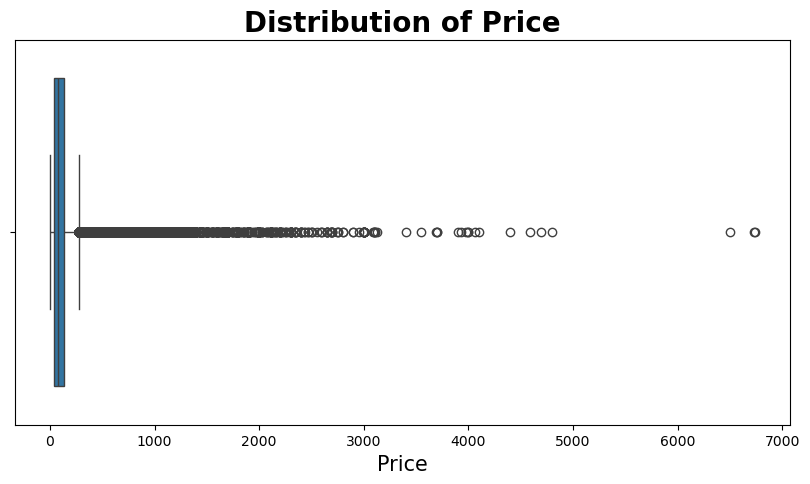

In [38]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='price', data=main)
plt.xlabel('Price',color='black',fontsize=15)
plt.title('Distribution of Price',color='black',fontsize=20,fontweight='bold')
plt.show()

In [39]:
Q1 = np.quantile(main.price, 0.25)
Q3 = np.quantile(main.price, 0.75)
IQR = Q3 - Q1
priceDistribution = main[~((main.price < Q1 - 1.5 * IQR) | (main.price > Q3 + 1.5 * IQR))]
priceDistribution.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_estimated_duration,order_delivery_time,...,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,15 days 13:03:27,6 days 01:30:13,...,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,19 days 03:18:23,12 days 00:56:45,...,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,26 days 15:21:11,9 days 04:16:29,...,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,26 days 04:31:54,9 days 10:48:43,...,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,12 days 02:41:21,1 days 22:30:28,...,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


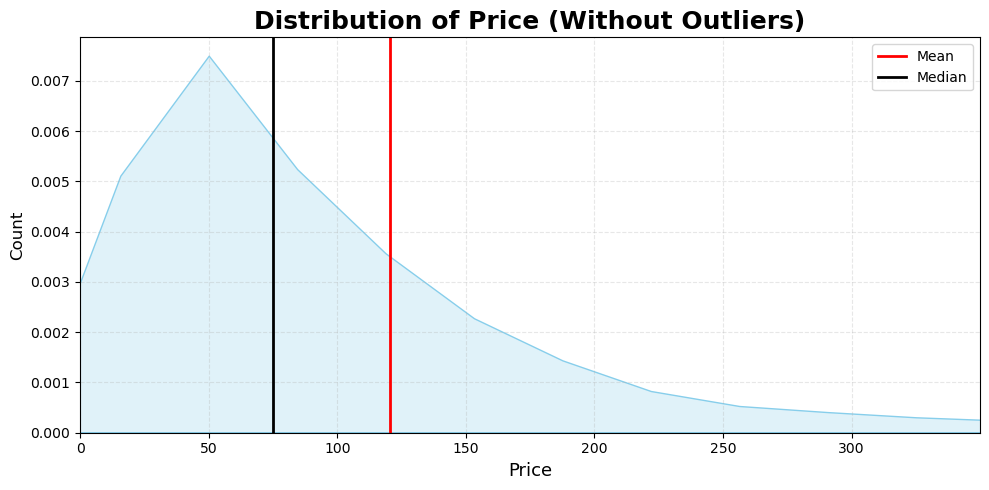

In [40]:
plt.figure(figsize=(10, 5))

# Plot with fewer bins and a smoother density curve
# sns.histplot(priceDistribution['price'], bins=40, kde=True, color='skyblue', edgecolor='black')
sns.kdeplot(priceDistribution['price'], fill=True, color='skyblue')


# Add mean and median lines
plt.axvline(priceDistribution['price'].mean(), c='red', linewidth=2, label='Mean')
plt.axvline(priceDistribution['price'].median(), c='black', linewidth=2, label='Median')

# Labels and formatting
plt.xlabel('Price', color='black', fontsize=13)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Price (Without Outliers)', color='black', fontsize=18, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3, linestyle='--')

# Focus on the main area where most prices lie
plt.xlim(0, priceDistribution['price'].quantile(0.95))  # trims far right tail

plt.tight_layout()
plt.show()

In [41]:
# Count number of orders per unique customer
customer_order_counts = main.groupby('customer_unique_id')['order_id'].nunique().reset_index(name='num_orders')

# Label customers as 'one_time' or 'repeat'
customer_order_counts['buyer_type'] = np.where(customer_order_counts['num_orders'] == 1, 'One-time', 'Repeat')

# Merge back to main dataset
main = main.merge(customer_order_counts[['customer_unique_id', 'buyer_type']], on='customer_unique_id', how='left')

# Calculate revenue per buyer type
revenue_comparison = main.groupby('buyer_type')['price'].sum().reset_index(name='total_revenue')
revenue_comparison['avg_revenue_per_order'] = main.groupby('buyer_type')['price'].mean().values

# Round to 2 decimals
revenue_comparison = revenue_comparison.round(2)

display(revenue_comparison)

,buyer_type,total_revenue,avg_revenue_per_order
0,One-time,12810926.37,121.93
1,Repeat,778821.97,102.91


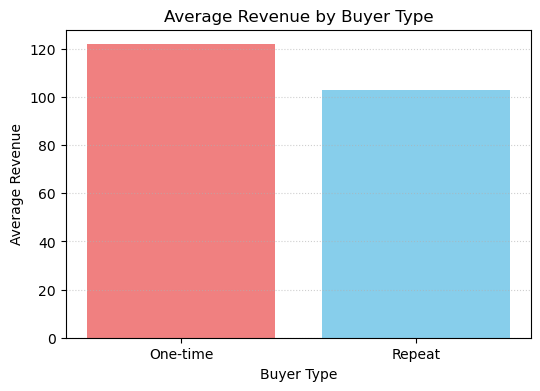

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(revenue_comparison['buyer_type'], revenue_comparison['avg_revenue_per_order'], color=['lightcoral', 'skyblue'])
plt.title('Average Revenue by Buyer Type')
plt.xlabel('Buyer Type')
plt.ylabel('Average Revenue')
plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.show()

In [43]:
main['order_date'] = main['order_purchase_timestamp'].dt.date

# Group by day to get both total orders and total revenue
top_order_days = (
    main.groupby('order_date')
    .agg(
        total_orders=('order_id', 'nunique'),
        total_revenue=('price', 'sum'),
        avg_order_value=('price', 'mean')
    )
    .reset_index()
    .sort_values(by='total_orders', ascending=False)
)

display(top_order_days.head())

,order_date,total_orders,total_revenue,avg_order_value
338,2017-11-24,1176,152653.74,111.752372
339,2017-11-25,499,60923.48,105.040483
341,2017-11-27,403,47923.66,101.104768
340,2017-11-26,391,45315.28,99.375614
342,2017-11-28,379,47769.25,111.091279


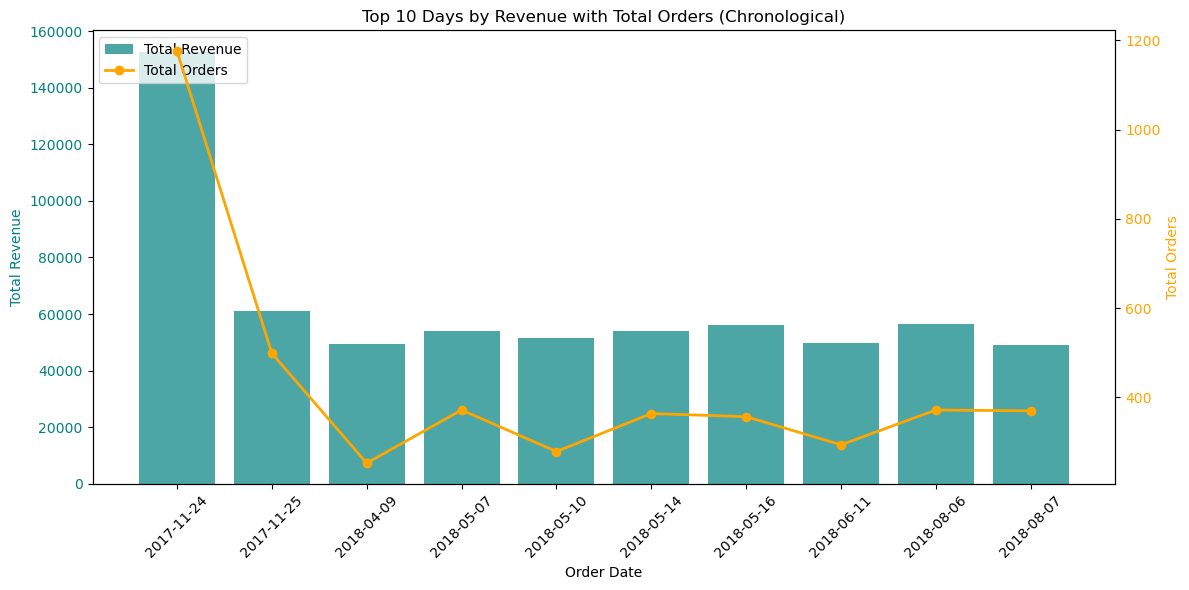

In [44]:
# Select the top 10 days by total revenue
top10_revenue_days = (
    top_order_days
    .nlargest(10, 'total_revenue')      # top 10 highest revenue days
    .sort_values('order_date')          # sort chronologically
)

fig, ax1 = plt.subplots(figsize=(12,6))

# --- Revenue (bar chart) ---
ax1.bar(
    top10_revenue_days['order_date'].astype(str),   # ensure x is string for clean labels
    top10_revenue_days['total_revenue'],
    color='teal', alpha=0.7, label='Total Revenue'
)

ax1.set_xlabel('Order Date')
ax1.set_ylabel('Total Revenue', color='teal')
ax1.tick_params(axis='y', labelcolor='teal')
ax1.tick_params(axis='x', rotation=45)  # rotate date labels for readability

# --- Orders (line chart on right axis) ---
ax2 = ax1.twinx()
ax2.plot(
    top10_revenue_days['order_date'].astype(str),
    top10_revenue_days['total_orders'],
    color='orange', marker='o', linewidth=2, label='Total Orders'
)

ax2.set_ylabel('Total Orders', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# --- Combine legends from both axes ---
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# --- Title & Layout ---
plt.title('Top 10 Days by Revenue with Total Orders (Chronological)')
fig.tight_layout()
plt.show()

**Observations**:
- The average revenue by customer type is relatively on par. So despite the ovherwhelming difference in numbers, the repeat buyers can still pull its leg in terms of revenue making.

## Product

In [47]:
products = products_df
products = (products
           .merge(product_cat_df,on = 'product_category_name',how='left'))

display(products['product_category_name'].nunique())
display(products['product_category_name_english'].nunique())

73

71

In [48]:
# Product category name portugese x english
products[products['product_category_name_english'].isnull()][['product_id','product_category_name']].value_counts()

product_id                        product_category_name                        
0105b5323d24fc655f73052694dbbb3a  pc_gamer                                         1
1220978a08a6b29a202bc015b18250e9  portateis_cozinha_e_preparadores_de_alimentos    1
1954739d84629e7323a4295812a3e0ec  portateis_cozinha_e_preparadores_de_alimentos    1
5d923ead886c44b86845f69e50520c3e  portateis_cozinha_e_preparadores_de_alimentos    1
6727051471a0fc4a0e7737b57bff2549  pc_gamer                                         1
6fd83eb3e0799b775e4f946bd66657c0  portateis_cozinha_e_preparadores_de_alimentos    1
7afdd65f79f63819ff5bee328843fa37  portateis_cozinha_e_preparadores_de_alimentos    1
a4756663d007b0cd1af865754d08d968  portateis_cozinha_e_preparadores_de_alimentos    1
ae62bb0f95af63d64eae5f93dddea8d3  portateis_cozinha_e_preparadores_de_alimentos    1
bed164d9d628cf0593003389c535c6e0  portateis_cozinha_e_preparadores_de_alimentos    1
c7a3f1a7f9eef146cc499368b578b884  portateis_cozinha_e_preparadores_de_

In [49]:
# Assuming your merged dataset is called 'df'
# The English names you want to use for the Portuguese categories:
category_mapping = {
    'portateis_cozinha_e_preparadores_de_alimentos': 'portable_kitchen_and_food_preparators',
    'pc_gamer': 'pc_gamer' # 'pc_gamer' is the desired English name for 'pc_gamer'
}

# 1. Create a boolean mask for the rows that meet the criteria:
#    a) The English name is null AND
#    b) The Portuguese name is one of the keys in the mapping dictionary
mask = (
    products['product_category_name_english'].isnull() &
    products['product_category_name'].isin(category_mapping.keys())
)

# 2. Use .loc to select these rows and apply the mapping to the English column:
# We use .map() to apply the translations based on the Portuguese column's value.
products.loc[mask, 'product_category_name_english'] = \
    products.loc[mask, 'product_category_name'].map(category_mapping)

print(products[products['product_category_name'].isin(category_mapping.keys())][
    ['product_category_name', 'product_category_name_english']
].head())

                              product_category_name  \
1628                                       pc_gamer   
5821  portateis_cozinha_e_preparadores_de_alimentos   
7325  portateis_cozinha_e_preparadores_de_alimentos   
7478                                       pc_gamer   
8819  portateis_cozinha_e_preparadores_de_alimentos   

              product_category_name_english  
1628                               pc_gamer  
5821  portable_kitchen_and_food_preparators  
7325  portable_kitchen_and_food_preparators  
7478                               pc_gamer  
8819  portable_kitchen_and_food_preparators  


In [50]:
products['product_category_name_english'].nunique()

73

In [51]:
#Only using the English name now.
products.drop('product_category_name',axis = 1, inplace=True)

In [52]:
#Filling the missing product category name with 'unkown'
products['product_category_name_english'].fillna('unknown', inplace=True)

C:\Users\naufa\AppData\Local\Temp\ipykernel_4664\2710168607.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  products['product_category_name_english'].fillna('unknown', inplace=True)


In [53]:
length_and_qty_cols = [
    'product_name_lenght',
    'product_description_lenght',
    'product_photos_qty'
]

print("Calculating means and imputing missing values:")

for col in length_and_qty_cols:
    # Calculate the mean (average) of the non-missing values
    mean_value = products[col].mean()
    
    # Fill the missing values (NaN) with the calculated mean
    products[col].fillna(mean_value, inplace=True)
    
    print(f"  - {col}: Filled missing values with the Mean ({mean_value:.2f})")

print("\nProduct length and quantity missing values filled with the mean.")

Calculating means and imputing missing values:
  - product_name_lenght: Filled missing values with the Mean (48.48)
  - product_description_lenght: Filled missing values with the Mean (771.50)
  - product_photos_qty: Filled missing values with the Mean (2.19)

Product length and quantity missing values filled with the mean.


C:\Users\naufa\AppData\Local\Temp\ipykernel_4664\758614211.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  products[col].fillna(mean_value, inplace=True)


In [54]:
#Now dropping the rest
products.dropna(inplace=True)
products.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32949 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_id                     32949 non-null  object 
 1   product_name_lenght            32949 non-null  float64
 2   product_description_lenght     32949 non-null  float64
 3   product_photos_qty             32949 non-null  float64
 4   product_weight_g               32949 non-null  float64
 5   product_length_cm              32949 non-null  float64
 6   product_height_cm              32949 non-null  float64
 7   product_width_cm               32949 non-null  float64
 8   product_category_name_english  32949 non-null  object 
dtypes: float64(7), object(2)
memory usage: 2.5+ MB


In [55]:
#Making product volumes
products['product_volume'] = products['product_length_cm'] * products['product_height_cm'] * products['product_width_cm']

#Gouped it by category and showing the mean sorted by the highest to lowest
average_volume_by_category = (
    products.groupby('product_category_name_english')['product_volume']
    .mean()
    # Chain the sort_values method with ascending=False to get the highest volume first
    .sort_values(ascending=False) 
)

average_volume_by_category.head()

product_category_name_english
furniture_mattress_and_upholstery          77244.300000
office_furniture                           75468.469256
kitchen_dining_laundry_garden_furniture    69406.095745
home_appliances_2                          55476.311111
furniture_living_room                      54486.128205
Name: product_volume, dtype: float64

In [56]:
main = main.merge(products, on = 'product_id', how='left')
main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113410 entries, 0 to 113409
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype          
---  ------                          --------------   -----          
 0   order_id                        113410 non-null  object         
 1   customer_id                     113410 non-null  object         
 2   order_status                    113410 non-null  object         
 3   order_purchase_timestamp        113410 non-null  datetime64[ns] 
 4   order_approved_at               113249 non-null  datetime64[ns] 
 5   order_delivered_carrier_date    111443 non-null  datetime64[ns] 
 6   order_delivered_customer_date   110189 non-null  datetime64[ns] 
 7   order_estimated_delivery_date   113410 non-null  datetime64[ns] 
 8   order_estimated_duration        113410 non-null  timedelta64[ns]
 9   order_delivery_time             110188 non-null  timedelta64[ns]
 10  order_delivery_delay            110189 non-n

In [57]:
# Calculate the correlation coefficient between volume and price
correlation = main['product_volume'].corr(main['price'])

print(f"The Pearson Correlation between Product Volume and Price is: {correlation:.4f}")

# Interpretation (Optional but helpful)
if correlation > 0.5:
    print("\nInterpretation: There is a strong positive correlation. Price tends to increase significantly with volume.")
elif correlation > 0.1:
    print("\nInterpretation: There is a weak to moderate positive correlation. Price generally increases with volume, but the relationship isn't very strong.")
elif correlation < -0.1:
    print("\nInterpretation: There is a weak to moderate negative correlation. Price tends to decrease as volume increases (unlikely for physical goods).")
else:
    print("\nInterpretation: There is a very weak or negligible linear correlation. Product price is largely independent of its physical volume.")

The Pearson Correlation between Product Volume and Price is: 0.2988

Interpretation: There is a weak to moderate positive correlation. Price generally increases with volume, but the relationship isn't very strong.


In [58]:
# Calculate the correlation coefficient between volume and price
correlation = main['product_volume'].corr(main['freight_value'])

print(f"The Pearson Correlation between Product Volume and Price is: {correlation:.4f}")

# Interpretation (Optional but helpful)
if correlation > 0.5:
    print("\nInterpretation: There is a strong positive correlation. Price tends to increase significantly with volume.")
elif correlation > 0.1:
    print("\nInterpretation: There is a weak to moderate positive correlation. Price generally increases with volume, but the relationship isn't very strong.")
elif correlation < -0.1:
    print("\nInterpretation: There is a weak to moderate negative correlation. Price tends to decrease as volume increases (unlikely for physical goods).")
else:
    print("\nInterpretation: There is a very weak or negligible linear correlation. Product price is largely independent of its physical volume.")

The Pearson Correlation between Product Volume and Price is: 0.5873

Interpretation: There is a strong positive correlation. Price tends to increase significantly with volume.


**Observations**:
- The volume of the products has a higher chance of increasing the shipping cost. While the price is contextual.

## Sellers

In [61]:
sellers = sellers_df.copy()
sellers.describe()
print()
sellers.describe(include='object')

,seller_id,seller_city,seller_state
count,3095,3095,3095
unique,3095,611,23
top,3442f8959a84dea7ee197c632cb2df15,sao paulo,SP
freq,1,694,1849


In [62]:
sellers.nunique()

seller_id                 3095
seller_zip_code_prefix    2246
seller_city                611
seller_state                23
dtype: int64

In [63]:
main = main.merge(sellers,on='seller_id',how='left')

In [64]:
# Creating Churners

#Define the Fixed Churn Threshold
CHURN_THRESHOLD_DAYS = 90
print(f"Defining a seller as churned if their Recency is greater than {CHURN_THRESHOLD_DAYS} days.")

# Data Preparation: Get Reference Date
# Convert timestamp column to datetime if not already done
# olist_alldata_df['order_purchase_timestamp'] = pd.to_datetime(olist_alldata_df['order_purchase_timestamp'])

last_date = main['order_purchase_timestamp'].max()

#Calculate Recency and Frequency (RF)
rf = (
    main.groupby('seller_id')
    .agg(
        # Recency: Days since the last transaction
        selling_recency=('order_purchase_timestamp', lambda x: (last_date - x.max()).days),
        # Frequency: Total number of transactions
        selling_frequency=('order_id', 'count')
    )
    .reset_index()
)

#Calculate Average Selling Interval
# Sort by seller_id and time to calculate the difference between sales
main = main.sort_values(['seller_id', 'order_purchase_timestamp'])

# Calculate the difference (time since last sale) in days
main['seller_days_since_last_order'] = (
    main.groupby('seller_id')['order_purchase_timestamp']
    .diff()
    .dt.days
)

# Calculate the average interval per seller
seller_intervals = (
    main.groupby('seller_id')['seller_days_since_last_order']
    .mean()
    .fillna(0) # One-time sellers have no interval, fill with 0
    .reset_index(name='avg_selling_interval')
)

# Merge interval data back into the RF table
rf = rf.merge(seller_intervals, on='seller_id', how='left')

#Define Churner using the Static Threshold
rf['seller_churner'] = (
    # Churn if Recency > Static Threshold
    (rf['selling_recency'] > CHURN_THRESHOLD_DAYS) &
    
    # Exclude one-time sellers from the churn count
    (rf['selling_frequency'] > 1) 
)

Defining a seller as churned if their Recency is greater than 90 days.


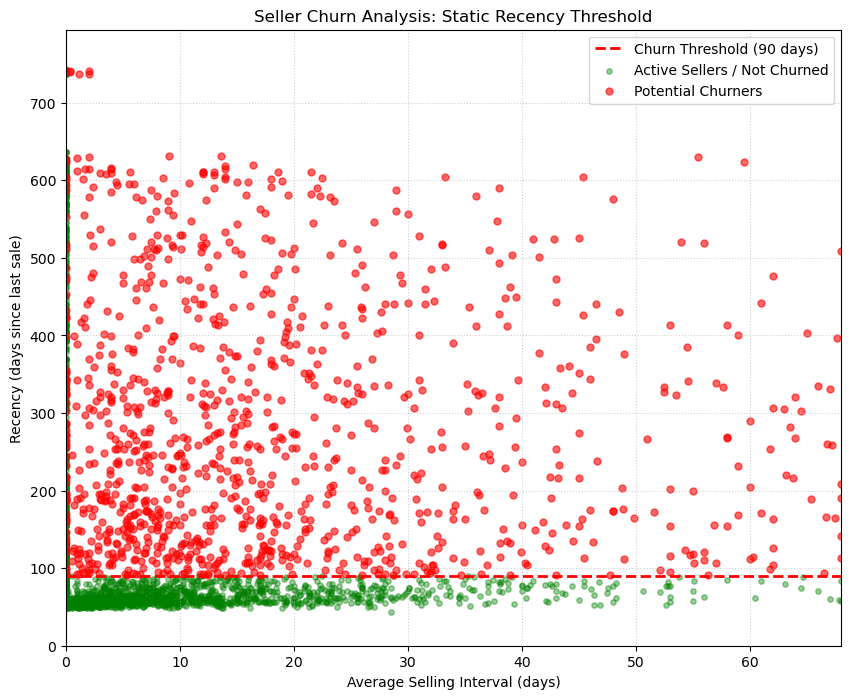


--- Final Churn Summary (Excluding One-Time Sellers) ---
Total Repeat Sellers (>1 Tx): 2584
Churners detected (Recency > 90 days): 1197
Churn Rate: 46.32%


In [65]:
#Visualization and Summary

# Plotting the Recency vs. Average Interval with the Static Threshold Line
plt.figure(figsize=(10, 8))

# Plot the threshold line (Recency = CHURN_THRESHOLD_DAYS)
plt.axhline(CHURN_THRESHOLD_DAYS, color='red', linestyle='--', linewidth=2, 
            label=f'Churn Threshold ({CHURN_THRESHOLD_DAYS} days)')

# Plot Active Sellers (Below the line or one-time sellers)
plt.scatter(
    rf.loc[~rf['seller_churner'], 'avg_selling_interval'],
    rf.loc[~rf['seller_churner'], 'selling_recency'],
    color='green',
    alpha=0.4,
    s=15,
    label='Active Sellers / Not Churned'
)

# Plot Potential Churners (Above the line and >1 transaction)
plt.scatter(
    rf.loc[rf['seller_churner'], 'avg_selling_interval'],
    rf.loc[rf['seller_churner'], 'selling_recency'],
    color='red',
    alpha=0.6,
    s=25,
    label='Potential Churners'
)

# Labels and title
plt.xlabel('Average Selling Interval (days)')
plt.ylabel(f'Recency (days since last sale)')
plt.title('Seller Churn Analysis: Static Recency Threshold')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.ylim(0, rf['selling_recency'].max() + 50) # Set Y limit
plt.xlim(0, rf['avg_selling_interval'].quantile(0.95)) # Focus on the bulk of data
plt.show()

# Final Summary
total_sellers = len(rf[rf['selling_frequency'] > 1])
churners_detected = rf['seller_churner'].sum()
churn_rate = (churners_detected / total_sellers) * 100

print("\n--- Final Churn Summary (Excluding One-Time Sellers) ---")
print(f"Total Repeat Sellers (>1 Tx): {total_sellers}")
print(f"Churners detected (Recency > {CHURN_THRESHOLD_DAYS} days): {churners_detected}")
print(f"Churn Rate: {churn_rate:.2f}%")

In [66]:
rf

,seller_id,selling_recency,selling_frequency,avg_selling_interval,seller_churner
0,0015a82c2db000af6aaaf3ae2ecb0532,364,3,10.000000,True
1,001cca7ae9ae17fb1caed9dfb1094831,96,239,1.819328,True
2,001e6ad469a905060d959994f1b41e4f,70,1,0.000000,False
3,002100f778ceb8431b7a1020ff7ab48f,188,55,3.462963,True
4,003554e2dce176b5555353e4f3555ac8,306,1,0.000000,False
...,...,...,...,...,...
3090,ffcfefa19b08742c5d315f2791395ee5,115,1,0.000000,False
3091,ffdd9f82b9a447f6f8d4b91554cc7dd3,59,20,27.526316,False
3092,ffeee66ac5d5a62fe688b9d26f83f534,156,14,16.923077,True
3093,fffd5413c0700ac820c7069d66d98c89,51,61,6.166667,False


In [67]:
#Merging them back to the main dataset:
churn_labels = rf.copy()

main = main.merge(churn_labels,
                 on='seller_id',
                 how='left'
                 )

print("Seller churn labels successfully merged into the main DataFrame.")
print("\nNew columns added:")
print(main[['seller_id', 'seller_churner']].head())
print("\nCheck for potential missing values (should be minimal, only for orders with no seller_id):")
print(main['seller_churner'].isnull().sum())

Seller churn labels successfully merged into the main DataFrame.

New columns added:
                          seller_id seller_churner
0  0015a82c2db000af6aaaf3ae2ecb0532           True
1  0015a82c2db000af6aaaf3ae2ecb0532           True
2  0015a82c2db000af6aaaf3ae2ecb0532           True
3  001cca7ae9ae17fb1caed9dfb1094831           True
4  001cca7ae9ae17fb1caed9dfb1094831           True

Check for potential missing values (should be minimal, only for orders with no seller_id):
775


In [68]:
main['buyer_type'].value_counts()

buyer_type
One-time    105735
Repeat        7675
Name: count, dtype: int64

In [69]:
df_main = main # Using 'main' as requested for the example

# Create a cross-tabulation of buyer_type and is_churner
# Normalize by 'index' (buyer_type) to show the percentage of CHURNED vs. ACTIVE 
# SELLERS *within* each buyer group (One-time, Repeat).
churn_by_buyer = pd.crosstab(
    df_main['buyer_type'],
    df_main['seller_churner'],
    normalize='index' 
) * 100

# Rename columns for clear output and sorting
churn_by_buyer.columns = ['Active Seller (%)', 'Churned Seller (%)']

# Print the resulting table
print("Distribution of Seller Churn Status by Buyer Type (Normalized by Buyer Type):")
print(churn_by_buyer.sort_values(by='Churned Seller (%)', ascending=False).to_markdown())

Distribution of Seller Churn Status by Buyer Type (Normalized by Buyer Type):
| buyer_type   |   Active Seller (%) |   Churned Seller (%) |
|:-------------|--------------------:|---------------------:|
| One-time     |             80.7485 |              19.2515 |
| Repeat       |             80.8272 |              19.1728 |


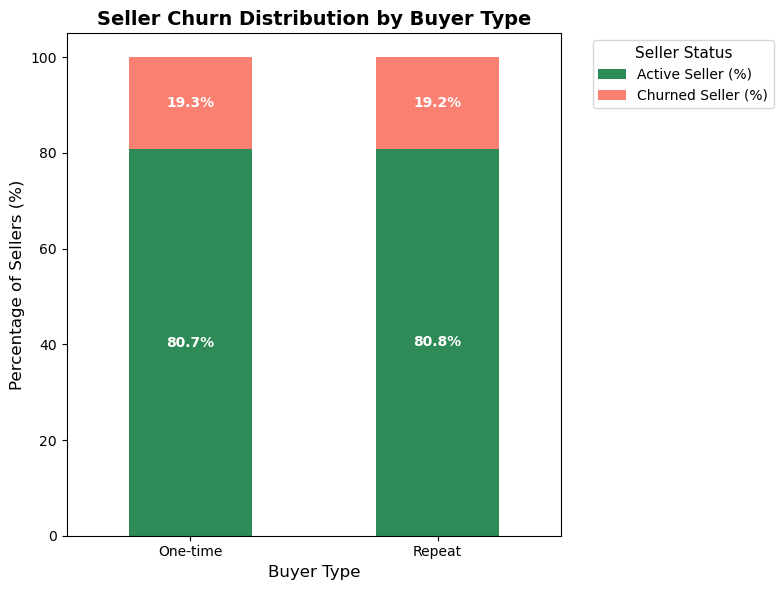

In [70]:
# Create the plot
ax = churn_by_buyer.plot(
    kind='bar',
    stacked=True,
    color=['seagreen', 'salmon'],
    figsize=(8, 6)
)

# Add percentage labels inside the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center', color='white', fontsize=10, fontweight='bold')

# Titles and labels
plt.title('Seller Churn Distribution by Buyer Type', fontsize=14, fontweight='bold')
plt.xlabel('Buyer Type', fontsize=12)
plt.ylabel('Percentage of Sellers (%)', fontsize=12)

# Legend setup
plt.legend(title='Seller Status', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=11)

# Final adjustments
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [71]:
# Calculate total and average revenue by seller churn status
revenue_by_seller_type = (
    main.groupby('seller_churner')['price']
    .agg(total_revenue='sum', avg_revenue_per_order='mean')
    .reset_index()
)

# Round to 2 decimals
revenue_by_seller_type = revenue_by_seller_type.round(2)

# Properly map boolean values to readable labels
revenue_by_seller_type['seller_churner'] = revenue_by_seller_type['seller_churner'].map({
    False: 'Active',
    True: 'Churned'
})

display(revenue_by_seller_type)

,seller_churner,total_revenue,avg_revenue_per_order
0,Active,10352337.49,113.82
1,Churned,3237410.85,149.34


In [72]:
main['seller_churner'].value_counts(dropna=False)

seller_churner
False    90957
True     21678
NaN        775
Name: count, dtype: int64

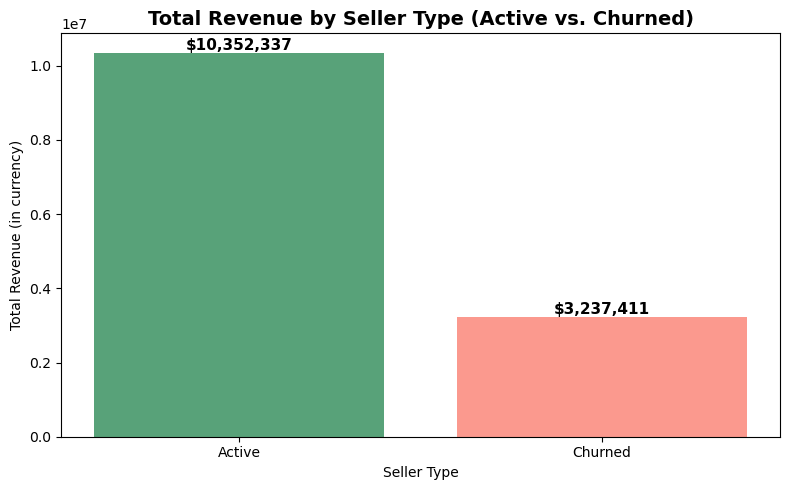

In [73]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,5))
bars = ax.bar(
    revenue_by_seller_type['seller_churner'],
    revenue_by_seller_type['total_revenue'],
    color=['seagreen', 'salmon'],
    alpha=0.8
)

# Label each bar with revenue values
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"${height:,.0f}",
        ha='center',
        va='bottom',
        fontsize=11,
        fontweight='bold'
    )

plt.title('Total Revenue by Seller Type (Active vs. Churned)', fontsize=14, fontweight='bold')
plt.xlabel('Seller Type')
plt.ylabel('Total Revenue (in currency)')
plt.tight_layout()
plt.show()

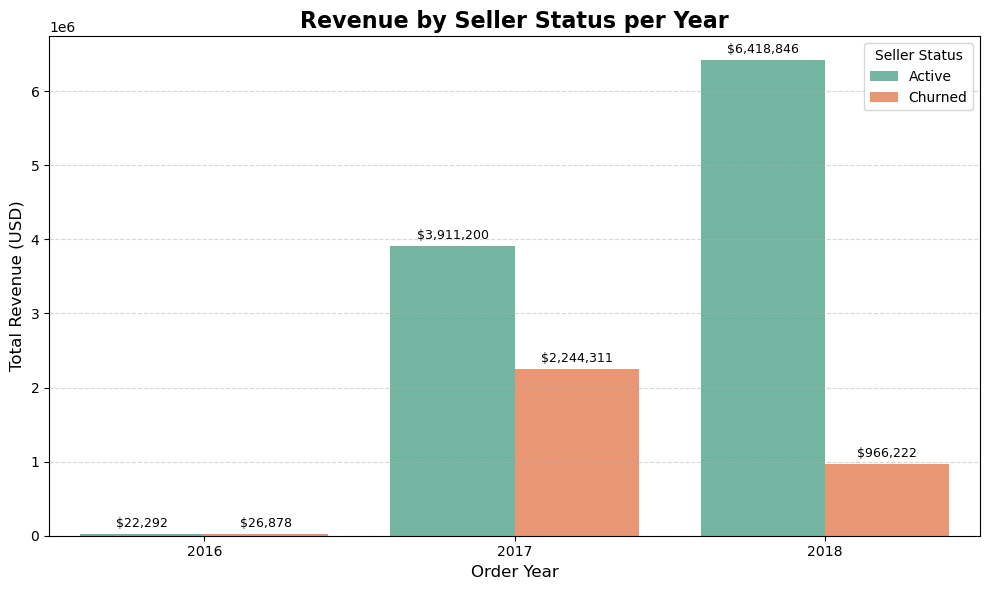

In [74]:
main['order_purchase_timestamp'] = pd.to_datetime(main['order_purchase_timestamp'])
main['order_year'] = main['order_purchase_timestamp'].dt.year

# Group by year and churn status
revenue_yearly = (
    main.groupby(['order_year', 'seller_churner'])['price']
    .sum()
    .reset_index(name='total_revenue')
)

# Map boolean → readable labels
revenue_yearly['seller_status'] = revenue_yearly['seller_churner'].map({
    False: 'Active',
    True: 'Churned'
})
revenue_yearly['seller_status'] = revenue_yearly['seller_status'].fillna('Unknown')

# Round and format
revenue_yearly['total_revenue'] = revenue_yearly['total_revenue'].round(2)

# --- Plot ---
plt.figure(figsize=(10,6))
ax = sns.barplot(
    data=revenue_yearly,
    x='order_year',
    y='total_revenue',
    hue='seller_status',
    palette='Set2'
)

# Add data labels on bars
for container in ax.containers:
    ax.bar_label(
        container,
        fmt='${:,.0f}',      # format as dollars, no decimals
        label_type='edge',   # label above the bar
        fontsize=9,
        padding=3,
        color='black'
    )

# Title and formatting
plt.title('Revenue by Seller Status per Year', fontsize=16, weight='bold')
plt.xlabel('Order Year', fontsize=12)
plt.ylabel('Total Revenue (USD)', fontsize=12)
plt.legend(title='Seller Status')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Geolocation

In [76]:
geolocation = geolocation_df.copy()
display(geolocation_df.head())
geolocation.info()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [77]:
# Checking Unique Values for Each Columns
print("\n--- Unique Values and Counts per Column ---")
for col in sellers_df.columns:
    print(f"\nColumn: {col}")
    unique_values = sellers_df[col].unique()
    num_unique = sellers_df[col].nunique()

    print(f"Number of unique values: {num_unique}")

    # Print unique values, but limit the output for columns with many unique values
    if num_unique > 20:
        print(f"Sample unique values: {unique_values[:20]}...")
    else:
        print(f"Unique values: {unique_values}")


--- Unique Values and Counts per Column ---

Column: seller_id
Number of unique values: 3095
Sample unique values: ['3442f8959a84dea7ee197c632cb2df15' 'd1b65fc7debc3361ea86b5f14c68d2e2'
 'ce3ad9de960102d0677a81f5d0bb7b2d' 'c0f3eea2e14555b6faeea3dd58c1b1c3'
 '51a04a8a6bdcb23deccc82b0b80742cf' 'c240c4061717ac1806ae6ee72be3533b'
 'e49c26c3edfa46d227d5121a6b6e4d37' '1b938a7ec6ac5061a66a3766e0e75f90'
 '768a86e36ad6aae3d03ee3c6433d61df' 'ccc4bbb5f32a6ab2b7066a4130f114e3'
 '8cb7c5ddf41f4d506eba76e9a4702a25' 'a7a9b880c49781da66651ccf4ba9ac38'
 '8bd0f31cf0a614c658f6763bd02dea69' '05a48cc8859962767935ab9087417fbb'
 '7b8e8ec35bad4b0ef7e3963650b0a87b' '1444c08e64d55fb3c25f0f09c07ffcf2'
 '166e8f1381e09651983c38b1f6f91c11' 'e38db885400cd35c71dfd162f2c1dbcf'
 'd2e753bb80b7d4faa77483ed00edc8ca' 'f9ec7093df3a7b346b7bcf7864069ca3']...

Column: seller_zip_code_prefix
Number of unique values: 2246
Sample unique values: [13023 13844 20031  4195 12914 20920 55325 16304  1529 80310 75110 13530
  1222  5372 

In [78]:
print("\n--- Checking for Missing Values ---")
geolocation.isnull().mean()*100


--- Checking for Missing Values ---


geolocation_zip_code_prefix    0.0
geolocation_lat                0.0
geolocation_lng                0.0
geolocation_city               0.0
geolocation_state              0.0
dtype: float64

In [79]:
print("\n--- Checking for Duplicate Rows ---")
duplicate_rows_geolocation = geolocation.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows_geolocation}")


--- Checking for Duplicate Rows ---
Number of duplicate rows: 261831


In [80]:
print("\n--- Checking for Duplicate Rows Across All Columns ---")
num_unique_rows_geolocation = geolocation.drop_duplicates().shape[0]
print(f"Number of unique rows: {num_unique_rows_geolocation}")

if num_unique_rows_geolocation < len(geolocation):
    print("There are duplicate rows across all columns in the geolocation dataset.")
else:
    print("There are no duplicate rows across all columns in the geolocation dataset.")


--- Checking for Duplicate Rows Across All Columns ---
Number of unique rows: 738332
There are duplicate rows across all columns in the geolocation dataset.


In [81]:
# Clean duplicates in geolocation
geolocation_clean = geolocation.groupby('geolocation_zip_code_prefix', as_index=False)[
    ['geolocation_lat', 'geolocation_lng']
].median()

In [82]:
# Make customer/seller geo merges
customers_geo = customers.merge(
    geolocation_clean,
    left_on='customer_zip_code_prefix',
    right_on='geolocation_zip_code_prefix',
    how='left'
).rename(columns={
    'geolocation_lat': 'geolocation_lat_customer',
    'geolocation_lng': 'geolocation_lng_customer'
})

sellers_geo = sellers.merge(
    geolocation_clean,
    left_on='seller_zip_code_prefix',
    right_on='geolocation_zip_code_prefix',
    how='left'
).rename(columns={
    'geolocation_lat': 'geolocation_lat_seller',
    'geolocation_lng': 'geolocation_lng_seller'
})

In [83]:
main = main.merge(
    customers_geo[['customer_id', 'geolocation_lat_customer', 'geolocation_lng_customer']],
    on='customer_id',
    how='left',
    suffixes=('', '_new') # Use suffixes to avoid conflicts if the column names were customer_state, etc.
)

# 3. Merge the SELLER geo data onto the full DataFrame
main = main.merge(
    sellers_geo[['seller_id', 'geolocation_lat_seller', 'geolocation_lng_seller']],
    on='seller_id',
    how='left',
    suffixes=('', '_new') # Use suffixes to avoid conflicts
)

print("✅ Final geo-merge successful (columns added, rows maintained)!")
print(main.info())

✅ Final geo-merge successful (columns added, rows maintained)!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113410 entries, 0 to 113409
Data columns (total 49 columns):
 #   Column                          Non-Null Count   Dtype          
---  ------                          --------------   -----          
 0   order_id                        113410 non-null  object         
 1   customer_id                     113410 non-null  object         
 2   order_status                    113410 non-null  object         
 3   order_purchase_timestamp        113410 non-null  datetime64[ns] 
 4   order_approved_at               113249 non-null  datetime64[ns] 
 5   order_delivered_carrier_date    111443 non-null  datetime64[ns] 
 6   order_delivered_customer_date   110189 non-null  datetime64[ns] 
 7   order_estimated_delivery_date   113410 non-null  datetime64[ns] 
 8   order_estimated_duration        113410 non-null  timedelta64[ns]
 9   order_delivery_time             110188 non-null  ti

In [84]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    # convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    km = 6371 * c  # Radius of earth in kilometers. Use 3956 for miles
    return km

# Calculate distance for each order
main['shipping_distance_km'] = main.apply(
    lambda row: haversine(
        row['geolocation_lat_customer'],
        row['geolocation_lng_customer'],
        row['geolocation_lat_seller'],
        row['geolocation_lng_seller']
    ) if pd.notnull(row['geolocation_lat_customer']) and pd.notnull(row['geolocation_lng_customer']) and pd.notnull(row['geolocation_lat_seller']) and pd.notnull(row['geolocation_lng_seller']) else None,
    axis=1
)

In [85]:
main['shipping_distance_km'].mean()

596.9229487634403

In [86]:
main['shipping_distance_km'].describe()

count    112081.000000
mean        596.922949
std         590.357428
min           0.000000
25%         183.103745
50%         431.740693
75%         791.897043
max        8677.859564
Name: shipping_distance_km, dtype: float64

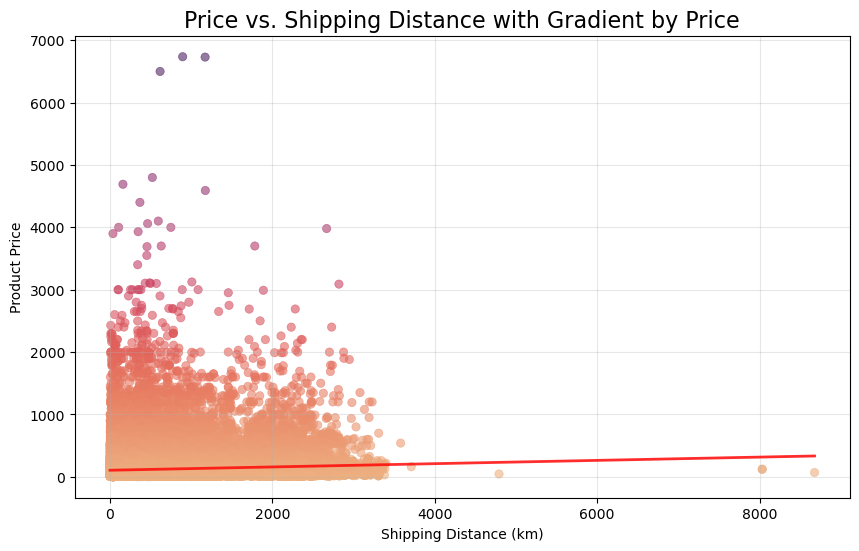

In [87]:
plt.figure(figsize=(10,6))

# Gradient scatter first
sns.scatterplot(
    data=main,
    x='shipping_distance_km',
    y='price',
    hue='price',                   # Color by price
    palette='flare',               # Try 'flare', 'magma', 'viridis', 'plasma', 'inferno' etc.
    alpha=0.6,
    edgecolor=None,
    legend=False
)

# Add regression line on top
sns.regplot(
    data=main,
    x='shipping_distance_km',
    y='price',
    scatter=False,
    color='red',
    line_kws={'lw':2, 'alpha':0.8}
)

plt.title('Price vs. Shipping Distance with Gradient by Price', fontsize=16)
plt.xlabel('Shipping Distance (km)')
plt.ylabel('Product Price')
plt.grid(alpha=0.3)
plt.show()

## Rating

In [89]:
rating = review_df.copy()

In [90]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [91]:
rating["review_answer_timestamp"] = (
    rating["review_answer_timestamp"]
    .apply(pd.to_datetime, format="%Y-%m-%d %H:%M:%S", errors='coerce')
)

In [92]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   review_id                99224 non-null  object        
 1   order_id                 99224 non-null  object        
 2   review_score             99224 non-null  int64         
 3   review_comment_title     11568 non-null  object        
 4   review_comment_message   40977 non-null  object        
 5   review_creation_date     99224 non-null  object        
 6   review_answer_timestamp  99224 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 5.3+ MB


In [93]:
main = main.merge(rating[['order_id','review_score']],on='order_id',how='left')
main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114077 entries, 0 to 114076
Data columns (total 51 columns):
 #   Column                          Non-Null Count   Dtype          
---  ------                          --------------   -----          
 0   order_id                        114077 non-null  object         
 1   customer_id                     114077 non-null  object         
 2   order_status                    114077 non-null  object         
 3   order_purchase_timestamp        114077 non-null  datetime64[ns] 
 4   order_approved_at               113915 non-null  datetime64[ns] 
 5   order_delivered_carrier_date    112098 non-null  datetime64[ns] 
 6   order_delivered_customer_date   110832 non-null  datetime64[ns] 
 7   order_estimated_delivery_date   114077 non-null  datetime64[ns] 
 8   order_estimated_duration        114077 non-null  timedelta64[ns]
 9   order_delivery_time             110831 non-null  timedelta64[ns]
 10  order_delivery_delay            110832 non-n

In [94]:
# main.to_csv("main_dataset_tableu.csv",index = False)
# # main.to_excel("main_dataset_tableu.xlsx", index = False)
# print("Document has been saved successfully!")

# Modelling

## Preparing the dataset

In [97]:
import sys # Read system parameters.
import seaborn as sns
import numpy as np                                          # Work with multi-dimensional arrays.
import pandas as pd                                         # Manipulate and analyze data.
import matplotlib                                           # Create and format charts.
import matplotlib.pyplot as plt
import category_encoders as ce                              # Encode data.
import sklearn                                              # Train and evaluate machine learning models.
from sklearn.model_selection import train_test_split, \
                                    learning_curve, \
                                    RandomizedSearchCV, \
                                    GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, \
                            confusion_matrix, \
                            f1_score, \
                            fbeta_score, \
                            recall_score, \
                            precision_score, \
                            RocCurveDisplay, \
                            PrecisionRecallDisplay, \
                            ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
import xgboost                                              # Build gradient boosting models.
from xgboost import XGBClassifier
import imblearn                                             # Deal with imbalanced data.
from imblearn.over_sampling import SMOTE                    # Perform oversampling.
from collections import Counter                             # Count objects in containers.
import pickle                                               # Save Python objects as binary files.
import warnings                                             # Suppress warnings.
warnings.filterwarnings('ignore')

# Ensure results are reproducible.
np.random.seed(1)

# Summarize software libraries used.
print('Libraries used in this project:')
print('- Python {}'.format(sys.version))
print('- NumPy {}'.format(np.__version__))
print('- pandas {}'.format(pd.__version__))
print('- Matplotlib {}'.format(matplotlib.__version__))
print('- Category Encoders {}'.format(ce.__version__))
print('- scikit-learn {}'.format(sklearn.__version__))
print('- XGBoost {}'.format(xgboost.__version__))
print('- imbalanced-learn {}\n'.format(imblearn.__version__))

Libraries used in this project:
- Python 3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]
- NumPy 1.26.4
- pandas 2.3.2
- Matplotlib 3.9.2
- Category Encoders 2.5.1.post0
- scikit-learn 1.2.2
- XGBoost 3.0.5
- imbalanced-learn 0.12.4



In [98]:
# Filter the DataFrame to include ONLY successfully delivered orders
df_delivered = main[main['order_status'] == 'delivered'].copy()

# Print the size of the new dataset
print(f"Original transaction count: {len(main)}")
print(f"Filtered (Delivered) transaction count: {len(df_delivered)}")

Original transaction count: 114077
Filtered (Delivered) transaction count: 110832


In [99]:
df_delivered['seller_id'].nunique()

2970

In [100]:
# --- Data Quality Checks & Cleanup ---
# 1. Drop rows where key transaction/product data is missing
df_delivered.dropna(subset=['product_id'], inplace=True)
print("Dropped rows where product/item data was missing.")

# --- Imputation Steps ---

# 2. Impute seller_days_since_last_order with 0 (for first transactions)
df_delivered['seller_days_since_last_order'].fillna(0, inplace=True)
print("seller_days_since_last_order filled with 0.")

# 3. Impute review_score with the Median
median_review_score = df_delivered['review_score'].median()
df_delivered['review_score'].fillna(median_review_score, inplace=True)
print(f"review_score filled with the Median ({median_review_score}).")

# 4. Impute Geolocation with Median grouped by State (to preserve context)
print("Starting Geolocation imputation by State Median...")

# Calculate Median Coordinates by State
lat_cust_median_by_state = df_delivered.groupby('customer_state')['geolocation_lat_customer'].median()
lng_cust_median_by_state = df_delivered.groupby('customer_state')['geolocation_lng_customer'].median()
lat_seller_median_by_state = df_delivered.groupby('seller_state')['geolocation_lat_seller'].median()
lng_seller_median_by_state = df_delivered.groupby('seller_state')['geolocation_lng_seller'].median()

# Apply State Median for Imputation
df_delivered['geolocation_lat_customer'] = df_delivered['geolocation_lat_customer'].fillna(df_delivered['customer_state'].map(lat_cust_median_by_state))
df_delivered['geolocation_lng_customer'] = df_delivered['geolocation_lng_customer'].fillna(df_delivered['customer_state'].map(lng_cust_median_by_state))
df_delivered['geolocation_lat_seller'] = df_delivered['geolocation_lat_seller'].fillna(df_delivered['seller_state'].map(lat_seller_median_by_state))
df_delivered['geolocation_lng_seller'] = df_delivered['geolocation_lng_seller'].fillna(df_delivered['seller_state'].map(lng_seller_median_by_state))

# Fill any residual NaNs (from states with no data) with the global median
geo_cols = ['geolocation_lat_customer', 'geolocation_lng_customer', 'geolocation_lat_seller', 'geolocation_lng_seller']
for col in geo_cols:
    df_delivered[col].fillna(df_delivered[col].median(), inplace=True)
print("Geolocation columns filled by State Median, then by global median for residuals.")

# 5. Impute Shipping Distance
df_delivered['shipping_distance_km'].fillna(df_delivered['shipping_distance_km'].median(), inplace=True)
print("Distance columns filled.")

# Final check
print("\nFinal missing value check for the cleaned delivered dataset (should be 0):")
print(df_delivered.isnull().sum()[df_delivered.isnull().sum() > 0])

Dropped rows where product/item data was missing.
seller_days_since_last_order filled with 0.
review_score filled with the Median (5.0).
Starting Geolocation imputation by State Median...
Geolocation columns filled by State Median, then by global median for residuals.
Distance columns filled.

Final missing value check for the cleaned delivered dataset (should be 0):
order_approved_at                15
order_delivered_carrier_date      1
order_delivery_time               1
order_delivery_time_hours         1
product_name_lenght              18
product_description_lenght       18
product_photos_qty               18
product_weight_g                 18
product_length_cm                18
product_height_cm                18
product_width_cm                 18
product_category_name_english    18
product_volume                   18
dtype: int64


In [101]:
# Dropping the last missing data
df_delivered.dropna(inplace=True)
df_delivered['seller_id'].nunique()

2970

## Seller Churners Dataset

In [103]:
seller_churner_classification_df = (
    df_delivered.groupby('seller_id')
    .agg(
        # --- Target Variable ---
        seller_churner=('seller_churner', 'first'),

        # --- RFM Metrics (Seller Activity) ---
        selling_recency=('selling_recency', 'first'),
        selling_frequency=('selling_frequency', 'first'),
        avg_selling_interval=('avg_selling_interval', 'first'),
        
        # --- Financial / Value ---
        avg_price=('price', 'mean'),
        total_sales_count=('price', 'count'),
        total_revenue=('price', 'sum'),
        avg_freight_value=('freight_value', 'mean'),

        # --- Performance / Logistics ---
        avg_delivery_delay=('order_delivery_delay_hours', 'mean'),
        avg_delivery_time=('order_delivery_time_hours', 'mean'),
        delay_rate=('order_arrival_status', 'mean'),
        # CHANGED TO MEDIAN
        avg_distance=('shipping_distance_km', 'median'),

        # --- Customer Quality (Repeat Buyer Ratio) ---
        repeat_buyer_ratio=('buyer_type', lambda x: (x == 'Repeat').sum() / x.count()),

        # --- Product Complexity & Diversity ---
        avg_weight=('product_weight_g', 'mean'),
        avg_volume=('product_volume', 'mean'),
        unique_products=('product_id', 'nunique'),
        unique_categories=('product_category_name_english', 'nunique'),

        # --- Location Features ---
        seller_state=('seller_state', 'first'),

        # --- Review / Customer Satisfaction ---
        avg_review_score=('review_score', 'mean'),          # Average rating
        review_count=('review_score', 'count'),              # Number of reviews
        low_rating_ratio=('review_score', lambda x: (x < 3).sum() / x.count() if x.count() > 0 else 0)  # % of low reviews
    )
    .reset_index()
)

In [104]:
seller_churner_classification_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2970 entries, 0 to 2969
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   seller_id             2970 non-null   object 
 1   seller_churner        2970 non-null   object 
 2   selling_recency       2970 non-null   float64
 3   selling_frequency     2970 non-null   float64
 4   avg_selling_interval  2970 non-null   float64
 5   avg_price             2970 non-null   float64
 6   total_sales_count     2970 non-null   int64  
 7   total_revenue         2970 non-null   float64
 8   avg_freight_value     2970 non-null   float64
 9   avg_delivery_delay    2970 non-null   float64
 10  avg_delivery_time     2970 non-null   float64
 11  delay_rate            2970 non-null   float64
 12  avg_distance          2970 non-null   float64
 13  repeat_buyer_ratio    2970 non-null   float64
 14  avg_weight            2970 non-null   float64
 15  avg_volume           

In [105]:
seller_churner_classification_df['seller_churner'] = seller_churner_classification_df['seller_churner'].astype(bool)

# This is the format required by most Scikit-learn classification models.
seller_churner_classification_df['seller_churner'] = seller_churner_classification_df['seller_churner'].astype(int)

# Verification
print("'seller_churner' successfully converted to binary integer (0 or 1).")
print(seller_churner_classification_df['seller_churner'].head())
print(seller_churner_classification_df['seller_churner'].dtype)

'seller_churner' successfully converted to binary integer (0 or 1).
0    1
1    1
2    1
3    0
4    1
Name: seller_churner, dtype: int32
int32


### Save Point

In [107]:
# seller_churner_classification_df.to_csv('clean_seller_master_features.csv', index=False)
# print("Saved clean_seller_master_features.csv (ready for OHE/modeling).")

### Importing Training Dataset

In [109]:
train_df = r"C:\Users\naufa\Documents\Purwadhika\Capstone Projects\04_Final Project\DataSet\02_Training\TRAINING_clean_seller_master_features_v2.csv"
seller_churner_classification_df = pd.read_csv(train_df)
print("Training dataset successfully imported!")

Training dataset successfully imported!


### Encoding

In [111]:
seller_churner_classification_df['seller_state'].value_counts()

seller_state
SP    1741
PR     327
MG     230
SC     179
RJ     159
RS     122
GO      38
DF      29
ES      21
BA      17
CE      11
PE       8
PB       5
MS       5
MT       4
RN       4
RO       2
SE       2
PI       1
PA       1
MA       1
AM       1
Name: count, dtype: int64

In [112]:
seller_classification_OH = pd.get_dummies(seller_churner_classification_df, columns=['seller_state'], dtype=int)

In [113]:
seller_classification_OH.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2908 entries, 0 to 2907
Data columns (total 43 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   seller_id             2908 non-null   object 
 1   seller_churner        2908 non-null   int64  
 2   selling_recency       2908 non-null   int64  
 3   selling_frequency     2908 non-null   int64  
 4   avg_selling_interval  2908 non-null   float64
 5   avg_price             2908 non-null   float64
 6   total_sales_count     2908 non-null   int64  
 7   total_revenue         2908 non-null   float64
 8   avg_freight_value     2908 non-null   float64
 9   avg_delivery_delay    2908 non-null   float64
 10  avg_delivery_time     2908 non-null   float64
 11  delay_rate            2908 non-null   float64
 12  avg_distance          2908 non-null   float64
 13  repeat_buyer_ratio    2908 non-null   float64
 14  avg_weight            2908 non-null   float64
 15  avg_volume           

### Target and Churners

In [115]:
leakage_features = [
    'selling_recency', 
    'avg_selling_interval',
    'seller_days_since_last_order'
]

# Define target and features properly
target_churn = seller_classification_OH['seller_churner']

# Select all feature columns except IDs and the target
features_churn = seller_classification_OH.drop(columns=['seller_id', 'seller_churner'] + leakage_features, errors='ignore')
# features_churn = seller_classification_OH.drop(columns=['seller_id', 'seller_churner','review_count','avg_review_score'] + leakage_features, errors='ignore')

print("Final Seller Classification DataFrame created: 'seller_churner_classification_df'.")
print(f"Total sellers ready for modeling: {len(seller_churner_classification_df)}")
print("\nTarget Distribution:")
print(seller_churner_classification_df['seller_churner'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')

Final Seller Classification DataFrame created: 'seller_churner_classification_df'.
Total sellers ready for modeling: 2908

Target Distribution:
seller_churner
0    61.42%
1    38.58%
Name: proportion, dtype: object


In [116]:
# Train 80%, Test 20%
X_train, X_test, y_train, y_test = train_test_split(
    features_churn,
    target_churn,
    test_size=0.2, 
    random_state=42,
    stratify=target_churn
)


print('Training-data features: ', X_train.shape)
print('Training-data target:   ', y_train.shape)

Training-data features:  (2326, 39)
Training-data target:    (2326,)


### Initial Pipeline

In [118]:
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, fbeta_score

# Custom F2 scorer (recall-weighted)
f2_scorer = make_scorer(fbeta_score, beta=2)

# Pipelines
pipes = {
    'LogisticRegression': Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('scaler', MinMaxScaler()),
        ('model', LogisticRegression(random_state=42))
    ]),
    'KNN': Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('scaler', MinMaxScaler()),
        ('model', KNeighborsClassifier())
    ]),
    'SVM': Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('scaler', MinMaxScaler()),
        ('model', SVC(probability=True, random_state=42))
    ]),
    'Decision Tree': Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('scaler', MinMaxScaler()),
        ('model', DecisionTreeClassifier(random_state=42,class_weight='balanced'))
    ]),
    'Random Forest': Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('scaler', MinMaxScaler()),
        ('model', RandomForestClassifier(random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('scaler', MinMaxScaler()),
        ('model', XGBClassifier(random_state=42))
    ]),
    'ADABoost': Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('scaler', MinMaxScaler()),
        ('model', AdaBoostClassifier(random_state=42))
    ])
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

# Evaluate each model
for name, pipe in pipes.items():
    print(f"\nEvaluating {name}...")
    scores = cross_validate(
        pipe, X_train, y_train,
        cv=cv,
        scoring={
            'accuracy': 'accuracy',
            'precision': 'precision',
            'recall': 'recall',
            'f1': 'f1',
            'f2': f2_scorer  # Add F2 scorer
        },
        n_jobs=-1
    )

    # Append to results DataFrame
    results.append({
        'Model': name,
        'Accuracy Mean': round(scores['test_accuracy'].mean(), 3),
        'Accuracy STD': round(scores['test_accuracy'].std(), 3),
        'Precision Mean': round(scores['test_precision'].mean(), 3),
        'Precision STD': round(scores['test_precision'].std(), 3),
        'Recall Mean': round(scores['test_recall'].mean(), 3),
        'Recall STD': round(scores['test_recall'].std(), 3),
        'F1 Mean': round(scores['test_f1'].mean(), 3),
        'F1 STD': round(scores['test_f1'].std(), 3),
        'F2 Mean': round(scores['test_f2'].mean(), 3),
        'F2 STD': round(scores['test_f2'].std(), 3)
    })

# Create summary DataFrame
df_cv_result = pd.DataFrame(results)

# ort by F2 (since false negatives matter most)
df_cv_result = df_cv_result.sort_values(by='F2 Mean', ascending=False).reset_index(drop=True)

print("\nModel Performance Summary:")
print()
df_cv_result


Evaluating LogisticRegression...

Evaluating KNN...

Evaluating SVM...

Evaluating Decision Tree...

Evaluating Random Forest...

Evaluating XGBoost...

Evaluating ADABoost...

Model Performance Summary:



,Model,Accuracy Mean,Accuracy STD,Precision Mean,Precision STD,Recall Mean,Recall STD,F1 Mean,F1 STD,F2 Mean,F2 STD
0,ADABoost,0.737,0.012,0.642,0.017,0.721,0.027,0.679,0.015,0.704,0.021
1,Random Forest,0.735,0.015,0.643,0.016,0.703,0.022,0.672,0.018,0.691,0.020
2,XGBoost,0.729,0.021,0.644,0.029,0.664,0.027,0.654,0.024,0.660,0.024
3,Decision Tree,0.689,0.019,0.586,0.020,0.659,0.035,0.620,0.026,0.643,0.031
4,KNN,0.586,0.028,0.465,0.034,0.474,0.042,0.469,0.034,0.472,0.037
5,LogisticRegression,0.638,0.015,0.540,0.024,0.400,0.039,0.459,0.033,0.422,0.037
6,SVM,0.640,0.029,0.561,0.066,0.300,0.047,0.390,0.054,0.330,0.050


### Hyperparameter Tuning Random Forest and XGBoost

In [122]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score

# Define F2 scorer
f2_scorer = make_scorer(fbeta_score, beta=2)

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

# Scoring dictionary
scoring_metrics = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'f2': f2_scorer
}

# Cross-validation for all models in your pipeline dictionary
for name, pipe in pipes.items():
    print(f"Running CV for: {name}")
    scores = cross_validate(
        estimator=pipe,
        X=X_train,
        y=y_train,
        cv=cv,
        scoring=scoring_metrics,
        n_jobs=-1
    )
    
    results.append({
        'Model': name,
        'Accuracy Mean': round(scores['test_accuracy'].mean(), 3),
        'Accuracy STD': round(scores['test_accuracy'].std(), 3),
        'Precision Mean': round(scores['test_precision'].mean(), 3),
        'Precision STD': round(scores['test_precision'].std(), 3),
        'Recall Mean': round(scores['test_recall'].mean(), 3),
        'Recall STD': round(scores['test_recall'].std(), 3),
        'F1 Mean': round(scores['test_f1'].mean(), 3),
        'F1 STD': round(scores['test_f1'].std(), 3),
        'F2 Mean': round(scores['test_f2'].mean(), 3),
        'F2 STD': round(scores['test_f2'].std(), 3)
    })

df_cv_result = pd.DataFrame(results)
print("\n=== Cross-Validation Results ===")
print(df_cv_result.sort_values(by='F2 Mean', ascending=False))

# Define param_grids for GridSearchCV
param_grids = {
    'Random Forest': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [5, 10, 15, None],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': ['sqrt', 'log2']
    },
    # 'XGBoost': {
    #     'model__n_estimators': [100, 200, 300],
    #     'model__max_depth': [3, 5, 7],
    #     'model__learning_rate': [0.01, 0.1, 0.2],
    #     'model__subsample': [0.7, 0.9, 1.0],
    #     'model__colsample_bytree': [0.7, 0.9, 1.0]
    # },
    'ADABoost': {
    'model__n_estimators': [50, 100, 200, 300],
    'model__learning_rate': [0.001, 0.01, 0.1, 1.0],
    'model__estimator': [
        DecisionTreeClassifier(max_depth=1),
        DecisionTreeClassifier(max_depth=2),
        DecisionTreeClassifier(max_depth=3)
    ]}
}

# Run GridSearchCV on the best-performing models
best_models = ['Random Forest', 'ADABoost']

for name in best_models:
    print(f"\nRunning GridSearch for {name}...")
    grid = GridSearchCV(
        estimator=pipes[name],
        param_grid=param_grids[name],
        scoring='f1',  # switch to f1 or f2
        cv=cv,
        n_jobs=-1,
        verbose=2
    )
    grid.fit(X_train, y_train)
    print("Best Params:", grid.best_params_)
    print("Best F2 Score:", grid.best_score_)

Running CV for: LogisticRegression
Running CV for: KNN
Running CV for: SVM
Running CV for: Decision Tree
Running CV for: Random Forest
Running CV for: XGBoost
Running CV for: ADABoost

=== Cross-Validation Results ===
                Model  Accuracy Mean  Accuracy STD  Precision Mean  \
6            ADABoost          0.737         0.012           0.642   
4       Random Forest          0.735         0.015           0.643   
5             XGBoost          0.729         0.021           0.644   
3       Decision Tree          0.689         0.019           0.586   
1                 KNN          0.586         0.028           0.465   
0  LogisticRegression          0.638         0.015           0.540   
2                 SVM          0.640         0.029           0.561   

   Precision STD  Recall Mean  Recall STD  F1 Mean  F1 STD  F2 Mean  F2 STD  
6          0.017        0.721       0.027    0.679   0.015    0.704   0.021  
4          0.016        0.703       0.022    0.672   0.018    0.6

### Model Final Run

#### XGBoost

XGBoost Best Param:
- Best Params: {'model__colsample_bytree': 0.7, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__n_estimators': 200, 'model__subsample': 0.7}

In [128]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import fbeta_score

xgb_final = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', MinMaxScaler()),
    ('model', XGBClassifier(
        colsample_bytree=0.9,
        learning_rate=0.01,
        max_depth=3,
        n_estimators=200,
        subsample=0.7,
        random_state=42))
])

xgb_final.fit(X_train,y_train)
xgb_y_pred = xgb_final.predict(X_test)

importances = xgb_final.named_steps['model'].feature_importances_

accuracy_score(y_test, xgb_y_pred)

print("\n--- Tuned XGB Performance ---")
print("Accuracy :", accuracy_score(y_test, xgb_y_pred))
print("Precision:", precision_score(y_test, xgb_y_pred))
print("Recall   :", recall_score(y_test, xgb_y_pred))
print("F1 Score :", f1_score(y_test, xgb_y_pred))
print("F2 Score :", fbeta_score(y_test, xgb_y_pred, beta=2)) 
# -----------------------

print("\nConfusion Matrix:\n", confusion_matrix(y_test, xgb_y_pred))
print("\nClassification Report:\n", classification_report(y_test, xgb_y_pred))


--- Tuned XGB Performance ---
Accuracy : 0.7233676975945017
Precision: 0.6118881118881119
Recall   : 0.7777777777777778
F1 Score : 0.684931506849315
F2 Score : 0.7377740303541315

Confusion Matrix:
 [[246 111]
 [ 50 175]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.69      0.75       357
           1       0.61      0.78      0.68       225

    accuracy                           0.72       582
   macro avg       0.72      0.73      0.72       582
weighted avg       0.75      0.72      0.73       582



In [130]:
import shap

xgb_model = xgb_final.named_steps['model']
scaler = xgb_final.named_steps['scaler']

# Scale the X_test data using the fitted scaler from the pipeline
X_test_scaled = scaler.transform(X_test)

# Convert the scaled test features back to a DataFrame for easy reading/plotting
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Use a sample of the test data for efficiency (SHAP can be slow on large datasets)
X_sample = X_test_scaled_df.sample(n=500, random_state=42)


# Initialize the Tree Explainer with the trained XGBoost model
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values for the sampled data
shap_values = explainer.shap_values(X_sample)


--- Global Feature Importance (SHAP Summary Plot) ---


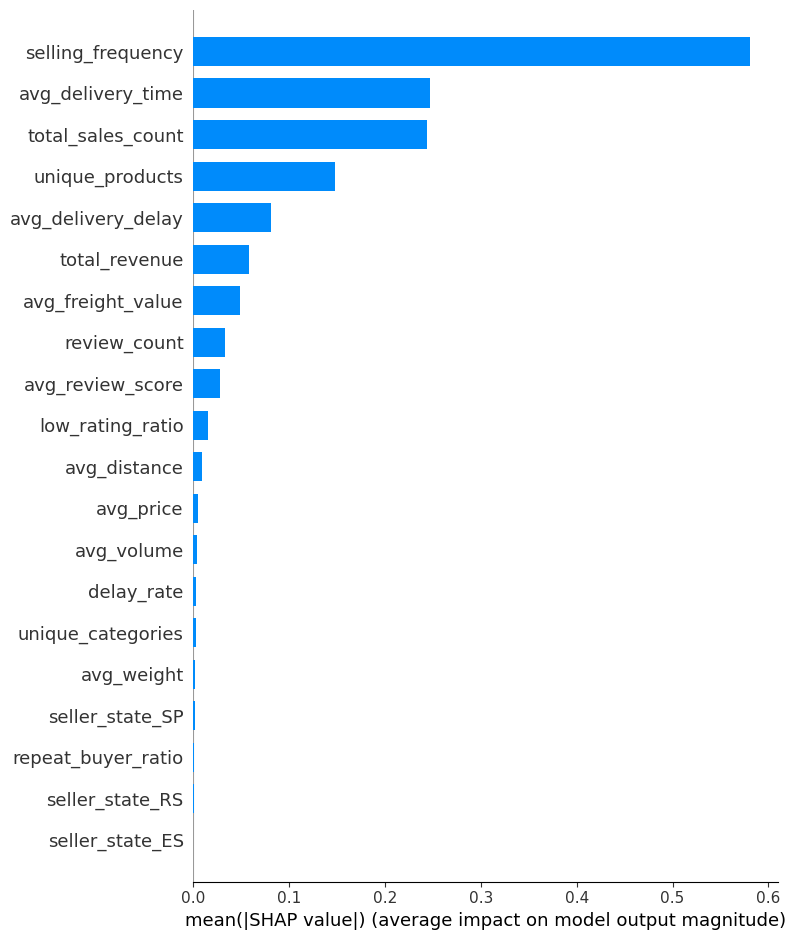

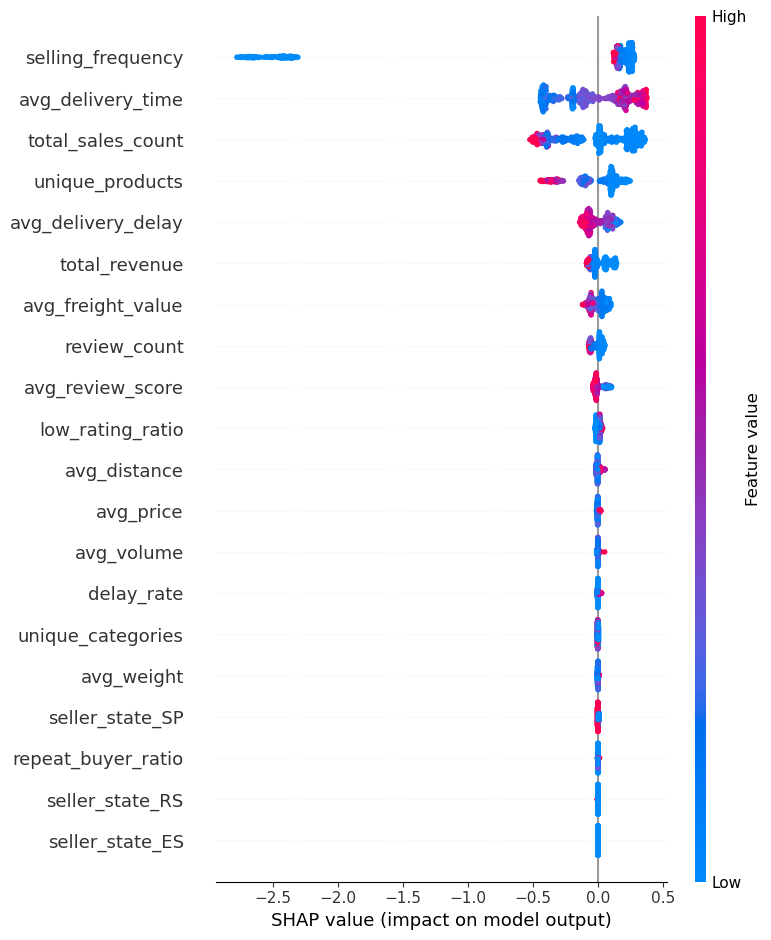

In [131]:
print("\n--- Global Feature Importance (SHAP Summary Plot) ---")
# Use the summary plot to visualize feature importance
shap.summary_plot(shap_values, X_sample, plot_type="bar") # Bar plot for overall magnitude
plt.show()

# Summary plot showing feature impact and direction (color)
shap.summary_plot(shap_values, X_sample)
plt.show()

In [133]:
# Select a random seller from the test set (e.g., the 5th observation)
sample_index = 5
seller_data = X_test_scaled_df.iloc[[sample_index]]
prediction = xgb_final.predict(X_test.iloc[[sample_index]])[0] # Predict on original data

print(f"\n--- Local Explanation for Seller #{sample_index} ---")
print(f"Model predicted Churn: {bool(prediction)}")

# Force plot for the single observation
# The "base value" is the average model output (expected value).
# Features pushing the prediction higher (towards 1/Churn) are red.
# Features pushing the prediction lower (towards 0/Active) are blue.
shap.initjs() # Necessary for rendering force plot in notebooks
shap.force_plot(explainer.expected_value, shap_values[sample_index], seller_data)


--- Local Explanation for Seller #5 ---
Model predicted Churn: False


#### Random Forest

Random Forest Best Param:
- Best Params: {'model__max_depth': 5, 'model__max_features': 'log2', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 300}
- Best Params: {'model__max_depth': 15, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 10, 'model__n_estimators': 200}

In [138]:
rf_final = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', MinMaxScaler()),
    ('model', RandomForestClassifier(
        max_depth=15,
        max_features='sqrt',
        min_samples_leaf=2,
        min_samples_split=10,
        n_estimators=200,
        random_state=42))
])

rf_final.fit(X_train,y_train)
rf_y_pred_tuned = rf_final.predict(X_test)

accuracy_score(y_test, rf_y_pred_tuned)

print("\n--- Tuned Random Forest Performance ---")
print("Accuracy :", accuracy_score(y_test, rf_y_pred_tuned))
print("Precision:", precision_score(y_test, rf_y_pred_tuned))
print("Recall   :", recall_score(y_test, rf_y_pred_tuned))
print("F1 Score :", f1_score(y_test, rf_y_pred_tuned))
print("F2 Score :", fbeta_score(y_test, rf_y_pred_tuned, beta=2)) 
# -----------------------

print("\nConfusion Matrix:\n", confusion_matrix(y_test, rf_y_pred_tuned))
print("\nClassification Report:\n", classification_report(y_test, rf_y_pred_tuned))


--- Tuned Random Forest Performance ---
Accuracy : 0.761168384879725
Precision: 0.6706349206349206
Recall   : 0.7511111111111111
F1 Score : 0.7085953878406708
F2 Score : 0.7335069444444444

Confusion Matrix:
 [[274  83]
 [ 56 169]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.77      0.80       357
           1       0.67      0.75      0.71       225

    accuracy                           0.76       582
   macro avg       0.75      0.76      0.75       582
weighted avg       0.77      0.76      0.76       582



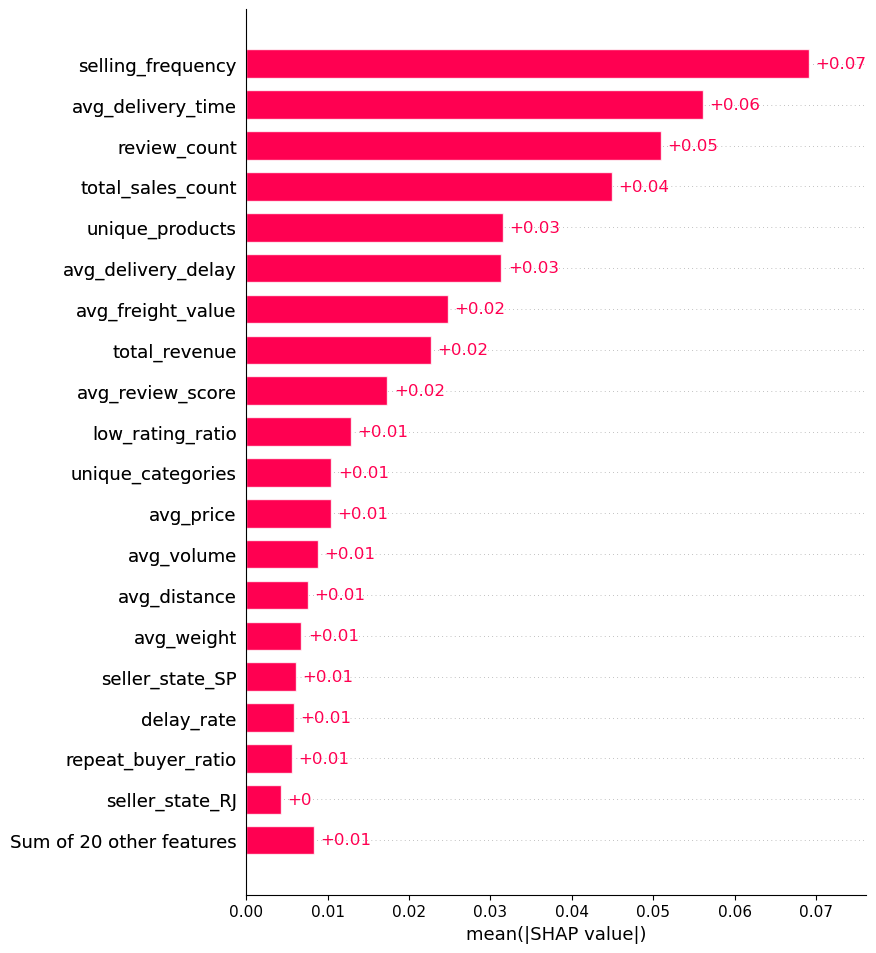

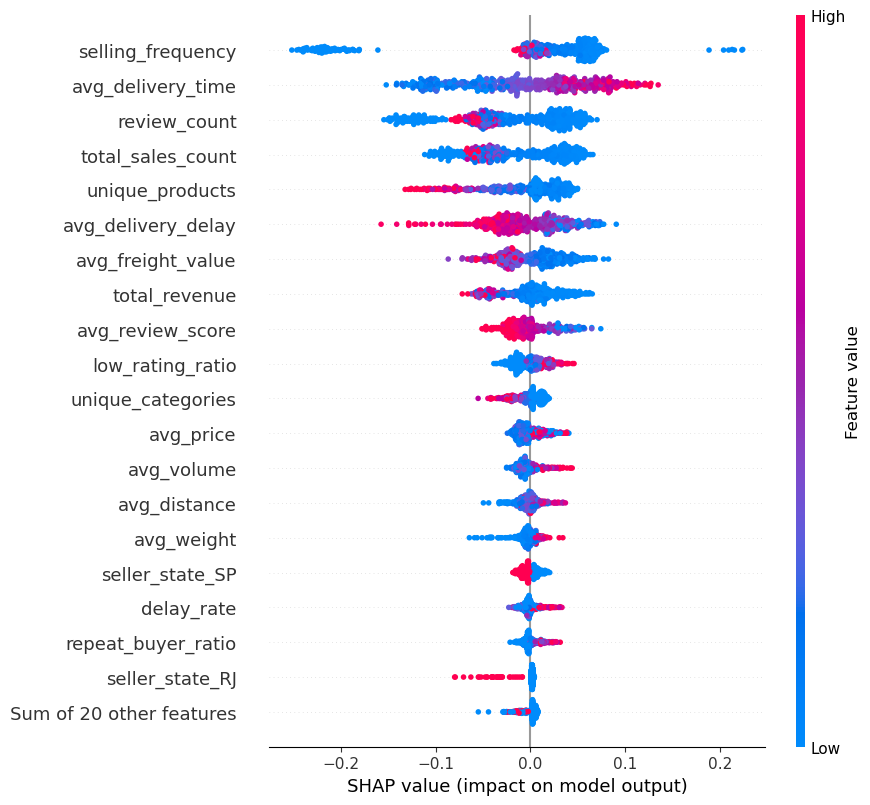

In [140]:
# --- Extract the trained model and scaler ---
rf_model = rf_final.named_steps['model']
scaler = rf_final.named_steps['scaler']

# --- Scale the test data using the same scaler ---
X_test_scaled_rf = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# --- Sample the data for efficiency ---
X_sample = X_test_scaled_rf.sample(n=500, random_state=42)

# # --- Create SHAP Explainer ---
explainer = shap.Explainer(rf_model)
shap_values = explainer(X_sample)

shap_values_class1 = shap_values[..., 1]

# Global feature importance
shap.plots.bar(shap_values_class1, max_display=20)

# Beeswarm for detailed impact
shap.plots.beeswarm(shap_values_class1, max_display=20)


--- Global Feature Importance (SHAP Summary Plot) ---


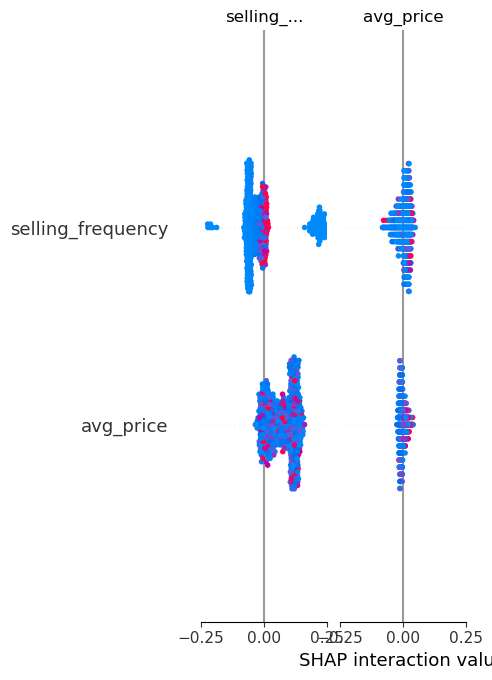

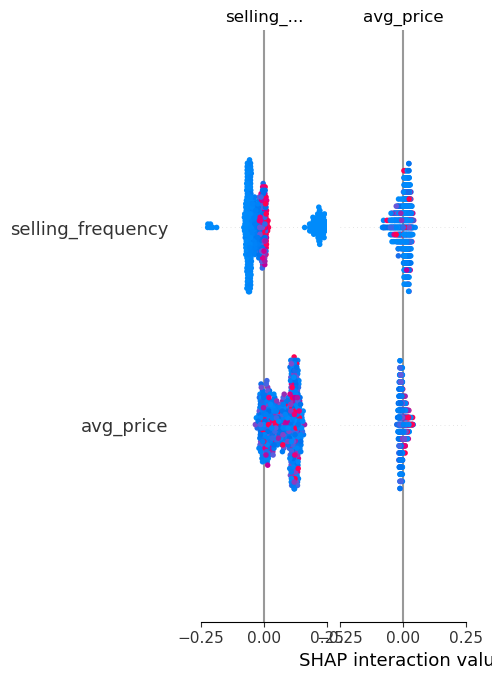

In [141]:
print("\n--- Global Feature Importance (SHAP Summary Plot) ---")
shap.summary_plot(shap_values, X_sample, plot_type="bar")
plt.show()

# --- Detailed Feature Impact ---
shap.summary_plot(shap_values, X_sample)
plt.show()

#### ADABoost

- Best Params: {'model__base_estimator': DecisionTreeClassifier(max_depth=1), 'model__learning_rate': 0.001, 'model__n_estimators': 50}

In [146]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import fbeta_score

ada_final = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', MinMaxScaler()),
    ('model', AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=300,
        learning_rate=0.1,
        random_state=42
    ))
])

ada_final.fit(X_train, y_train)
ada_pred = ada_final.predict(X_test)

print("\n--- Tuned AdaBoost Performance ---")
print("Accuracy :", accuracy_score(y_test, ada_pred))
print("Precision:", precision_score(y_test, ada_pred))
print("Recall   :", recall_score(y_test, ada_pred))
print("F1 Score :", f1_score(y_test, ada_pred))
print("F2 Score :", fbeta_score(y_test, ada_pred, beta=2))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, ada_pred))
print("\nClassification Report:\n", classification_report(y_test, ada_pred))


--- Tuned AdaBoost Performance ---
Accuracy : 0.7336769759450171
Precision: 0.6258992805755396
Recall   : 0.7733333333333333
F1 Score : 0.6918489065606361
F2 Score : 0.7385398981324278

Confusion Matrix:
 [[253 104]
 [ 51 174]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.71      0.77       357
           1       0.63      0.77      0.69       225

    accuracy                           0.73       582
   macro avg       0.73      0.74      0.73       582
weighted avg       0.75      0.73      0.74       582



PermutationExplainer explainer: 501it [09:27,  1.14s/it]                                                               


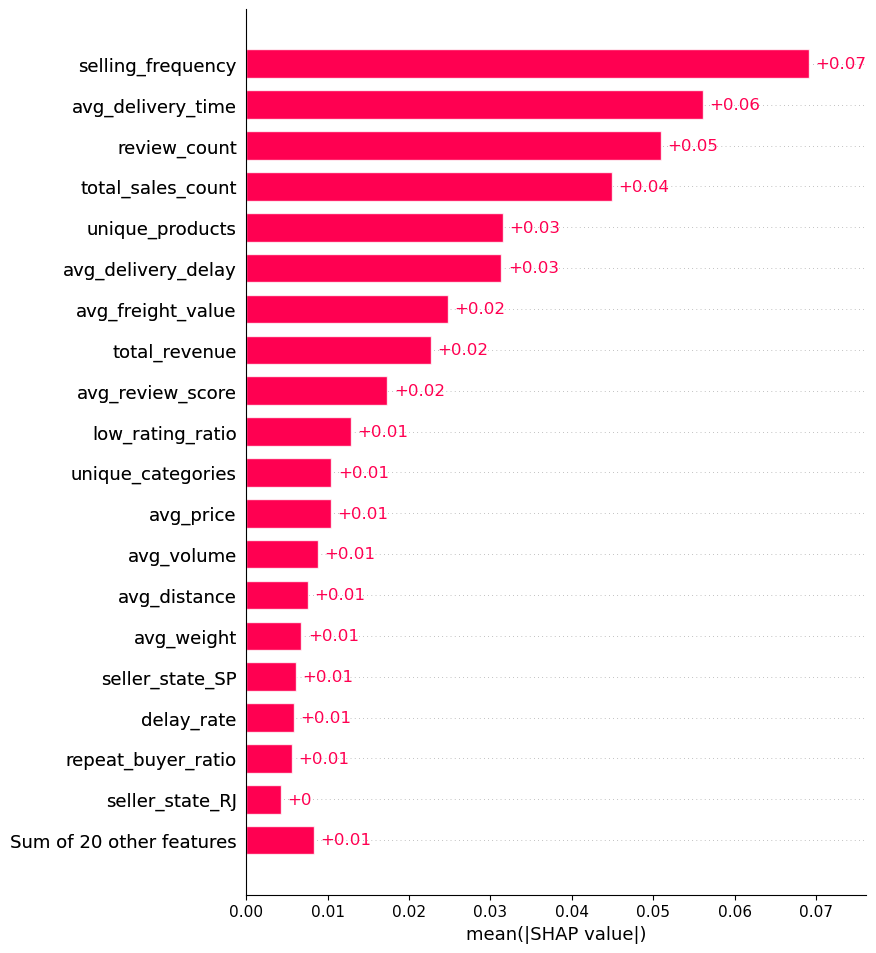

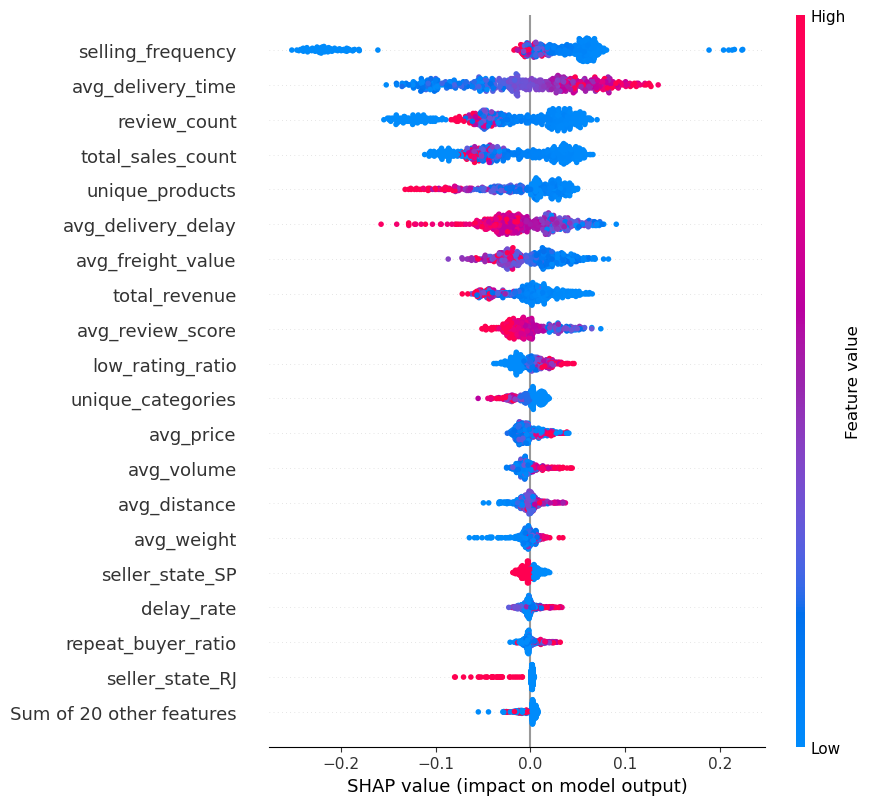

In [147]:
# --- Extract the trained model and scaler ---
ada_model = ada_final.named_steps['model']
scaler = ada_final.named_steps['scaler']

# --- Scale the test data using the same scaler ---
X_test_scaled_ada = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# --- Sample the data for efficiency ---
X_sample = X_test_scaled_ada.sample(n=500, random_state=42)

# # --- Create SHAP Explainer ---
def predict_proba_churn(data):
    return ada_model.predict_proba(data)[:, 1]

explainer = shap.Explainer(predict_proba_churn, X_sample)
# explainer = shap.Explainer(ada_model)
# # shap_values = explainer(X_sample)

# shap_values_class1 = shap_values[..., 1]
shap_values = explainer(X_sample)


# Global feature importance
shap.plots.bar(shap_values_class1, max_display=20)

# Beeswarm for detailed impact
shap.plots.beeswarm(shap_values_class1, max_display=20)


--- Global Feature Importance (SHAP Summary Plot) ---


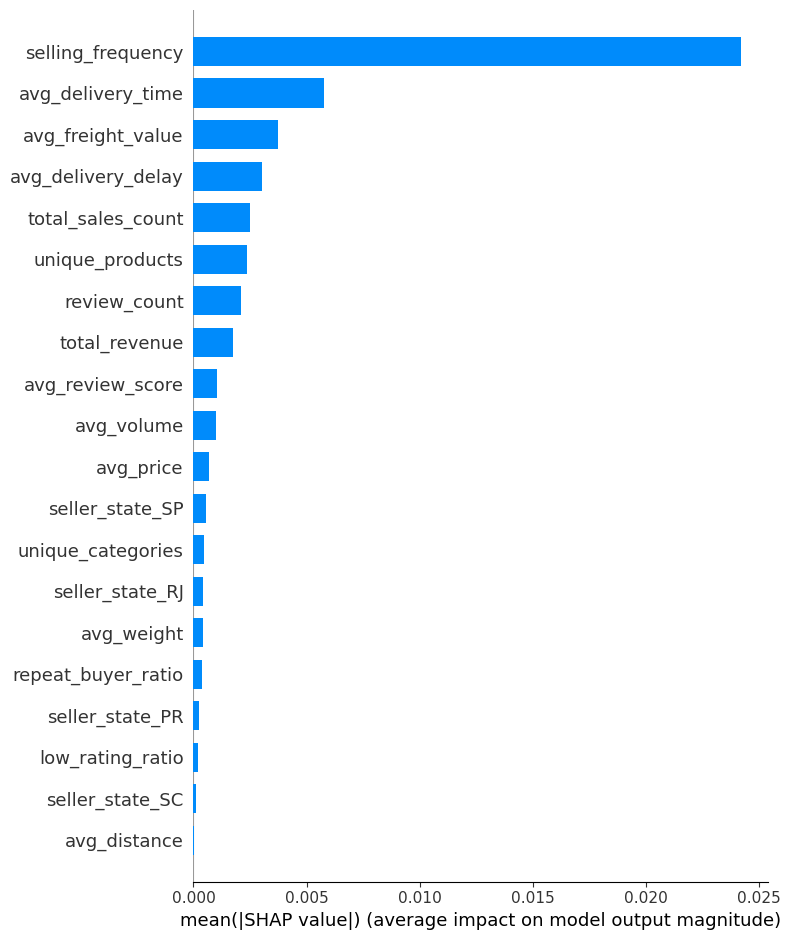

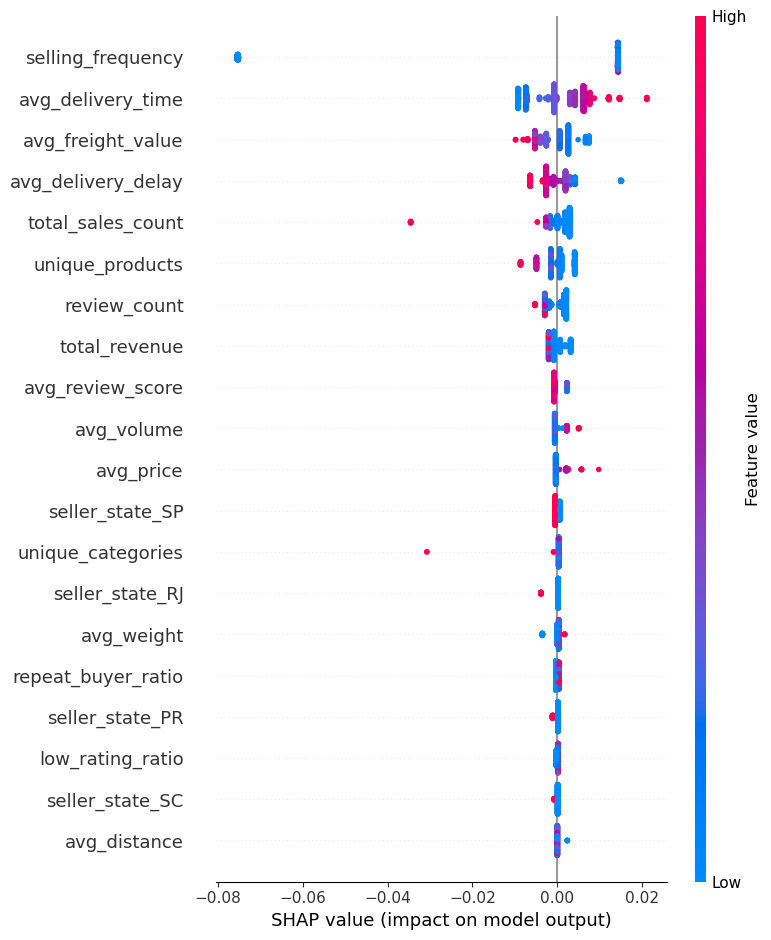

In [150]:
print("\n--- Global Feature Importance (SHAP Summary Plot) ---")
shap.summary_plot(shap_values, X_sample, plot_type="bar")
plt.show()

# --- Detailed Feature Impact ---
shap.summary_plot(shap_values, X_sample)
plt.show()

### Saving the best model - Random Forest

In [153]:
import pickle

# # Save your final Random Forest pipeline
with open('rf_final_model_v2.pkl', 'wb') as file:
    pickle.dump(rf_final, file)

print("✅ Model saved successfully as 'rf_final_model.pkl'")

✅ Model saved successfully as 'rf_final_model.pkl'


In [ ]:
# import pickle

# # Save your final Random Forest pipeline
# with open('xgb_final_model_v2.pkl', 'wb') as file:
#     pickle.dump(xgb_final, file)

# print("✅ Model saved successfully as 'xgb_final_model.pkl'")

In [155]:
import pickle

# # Save your final ADABoost pipeline
with open('ada_final_model_v2.pkl', 'wb') as file:
    pickle.dump(ada_final, file)

print("✅ Model saved successfully as 'rf_final_model.pkl'")

✅ Model saved successfully as 'rf_final_model.pkl'
